# Analyse des utilisateurs

On cherche à analyser les données du fichier train_users_2.csv. 

In [116]:
import pandas as pd
import numpy as np
from functools import reduce
from matplotlib import cm
import matplotlib.pyplot as plt
import calendar
import seaborn as sns

plt.style.use('seaborn-poster')
plt.rcParams.update({'font.size': 12})

On va importer les données, ajouter la variable "destination_found" qui aura pour valeur NDF ("No Destination Found") ou DF (Destination Found) et rééquilibrer les classes NDF et DF en selectionant $n$ données de chaque classe. Ici, $n=88000$. On finit par mélanger les données.

In [117]:
# Import data
n = 88000
users = pd.read_csv('./data/train_users_2.csv', sep=',')
users['destination_found'] = users.apply(lambda r: 'NDF' if r['country_destination'] == 'NDF' else 'DF', axis=1)
users = pd.concat([users[users['destination_found'] == 'NDF'].head(n), users[users['destination_found'] == 'DF'].head(n)]).sample(frac=1).reset_index(drop=True)
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_found
0,7ynnpgkdbx,2014-03-14,20140314015922,2014-09-15,FEMALE,45.0,basic,0,en,seo,facebook,product,Web,Windows Desktop,Chrome,US,DF
1,q19b35e1xw,2013-10-02,20131002054341,NaN,FEMALE,35.0,facebook,0,en,sem-brand,google,omg,Web,Windows Desktop,Chrome,NDF,NDF
2,gmh88om2yq,2013-12-11,20131211071301,2014-01-26,FEMALE,38.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,US,DF
3,fjrod56as4,2014-04-09,20140409202226,2014-05-08,MALE,26.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,DF
4,eq60wgvfwm,2013-07-09,20130709001011,NaN,-unknown-,39.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Safari,NDF,NDF


## Analyse des données générales

On dispose de 15 variables :
* **id** : identifiant de l'utilisateur (unique)
* **date_account_created** : date à laquelle l'utilisateur s'est inscrit sur le site
* **timestamp_first_active** : date et heure à laquelle l'utilisateur s'est rendu sur le site pour la première fois, peut être antérieur à la variable précédente
* **date_first_booking** : date de la réservation s'il y a lieu
* **gender** : sexe de l'utilisateur
* **age** : age de l'utilisateur
* **signup_method** : méthode utilisée par l'utilisateur pour se connecter
* **signup_flow** : numéro de la page de recherche à laquelle l'utilisateur s'est décidé de s'inscrire
* **language** : la langue par défaut du navigateur de l'utilisateur
* **affiliate_channel** : le canal d'affiliation
* **affiliate_provider** : 
* **first_affiliate_tracked** : 
* **signup_app** : application utilisée par l'utilisateur pour se connecter
* **first_device_type** : type du premier appareil détecté
* **first_browser** : premier navigateur détecté

### Gender

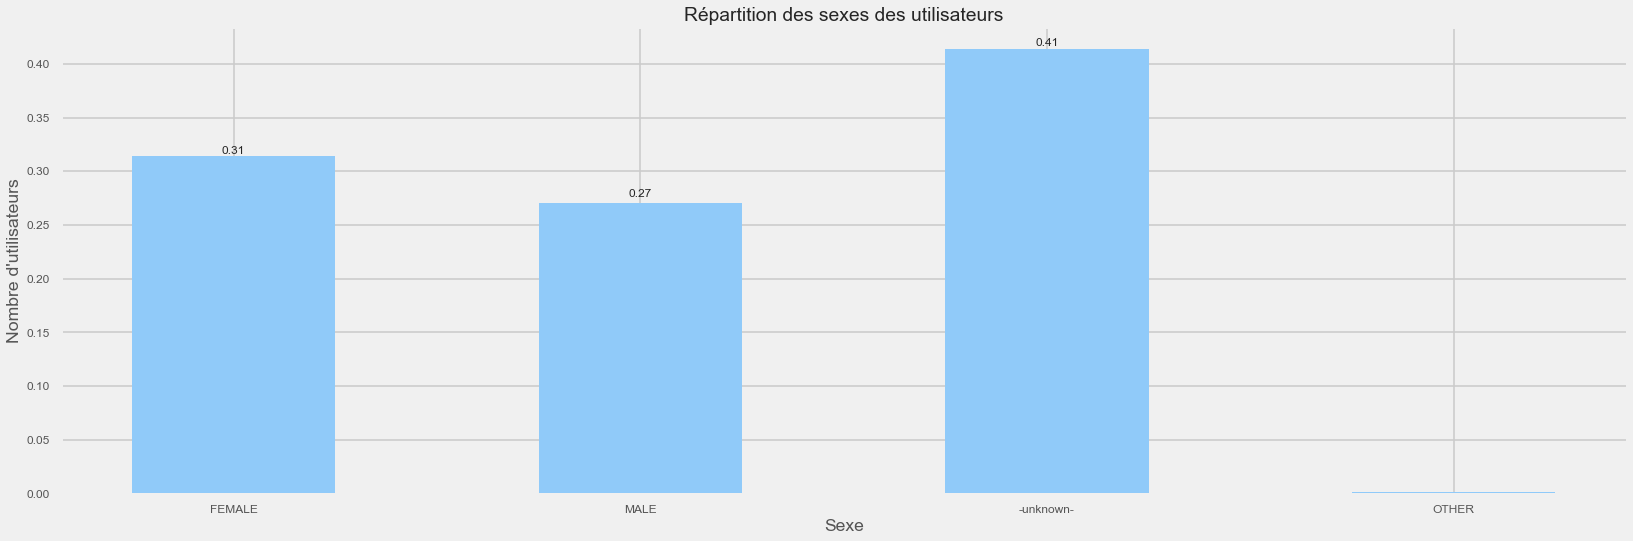

In [118]:
# Function borrowed from https://stackoverflow.com/questions/47805767/why-does-pyplot-plot-create-an-additional-rectangle-with-width-1-height-1/47812553#47812553
def autolabel(rects, ax):
    '''Adds quantities at the top of bars'''
    for rect in rects:
        x = round(rect.get_x() + rect.get_width()/2., 2)
        y = round(rect.get_height(), 2)
        ax.annotate("{}".format(y), (x,y), xytext=(0,5), textcoords="offset points", ha='center', va='bottom') if y > 0 else 0

ax = users['gender'].hist(figsize=(25, 8), bins=np.arange(5)-0.5, rwidth=0.5, density=True, color='#90caf9')
ax.tick_params(labelsize=12)
ax.set_xlabel('Sexe')
ax.set_ylabel("Nombre d'utilisateurs")
ax.set_title("Répartition des sexes des utilisateurs")    
autolabel(ax.patches,ax)

On distingue 4 valeurs possibles pour "gender" : "MALE", "FEMALE", "-unknown-" et OTHER. 
* La valeur "-unknown-" est majoritairement représentée avec 41% d'utilisateurs.
* On voit qu'il y a un peu plus de femmes (31%) que d'homme (27%) dans ces données. 
* La valeur "OTHER" est sous représentée très minoritaire (avec seulement 261 représentants en réalité). 

Ainsi, la pluplart des utilisateurs ne donnent pas d'information concernant leur sexe. Vérifions s'il n'y aurait pas de corrélation avec les variables cibles.

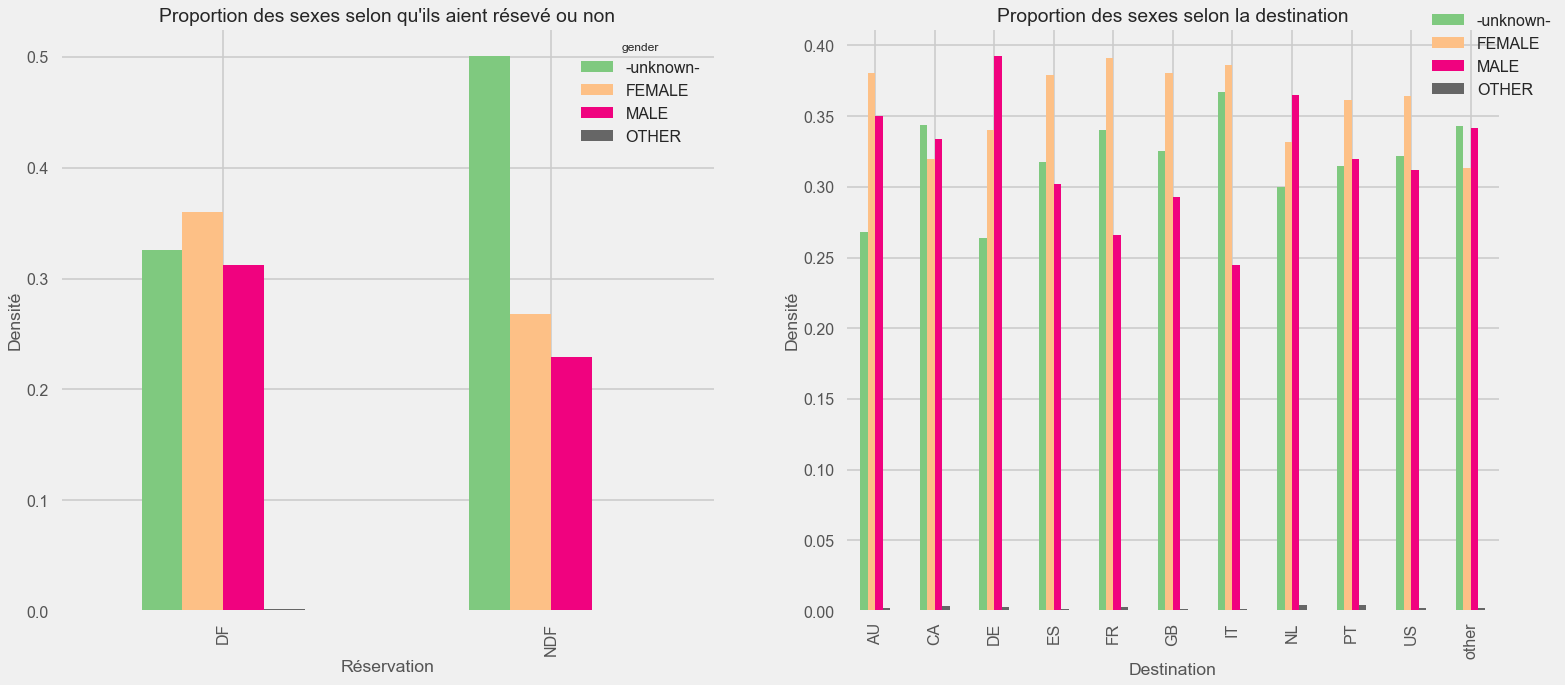

In [119]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(23, 10))
var = pd.crosstab(users['destination_found'], users['gender'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='Accent')
ax1.set_ylabel('Densité')
ax1.set_xlabel('Réservation')
ax1.set_title("Proportion des sexes selon qu'ils aient résevé ou non")

df_users = users[users['destination_found'] == 'DF']
var = pd.crosstab(df_users['country_destination'], df_users['gender'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='Accent')
ax2.set_ylabel('Densité')
ax2.set_xlabel('Destination')
plt.legend(bbox_to_anchor=(1.1, 1.05))
_ = ax2.set_title("Proportion des sexes selon la destination")

* La valeur "-unknown-" est représenté à 50% parmi les NDF.
* Les utilisateurs qui ont renseigné leur sexe ont tendence à réserver une destination.

Au niveau de la distribution par pays, on voit que : 
* les utilisateurs ayant réservé en Allemagne (DE) et aux Pays-Bas (NL) sont plus généralement des hommes à 39% et 37%.
* celles ayant réservé en Italie (IT), France (FR) et Grande-Bretagne (GB) sont plus souvent des femmes à 38% environ pour les 3 pays. 

Pour les autres pays, la différence est trop faible pour établir une quelconque conclusion. Souvent, il peut être normalement de voir que le nombre de femmes est légèrement supérieur au nombre d'homme chez certains pays puisque le nombre total de femmes dans ces données supérieur à celui de l'homme.

### Age

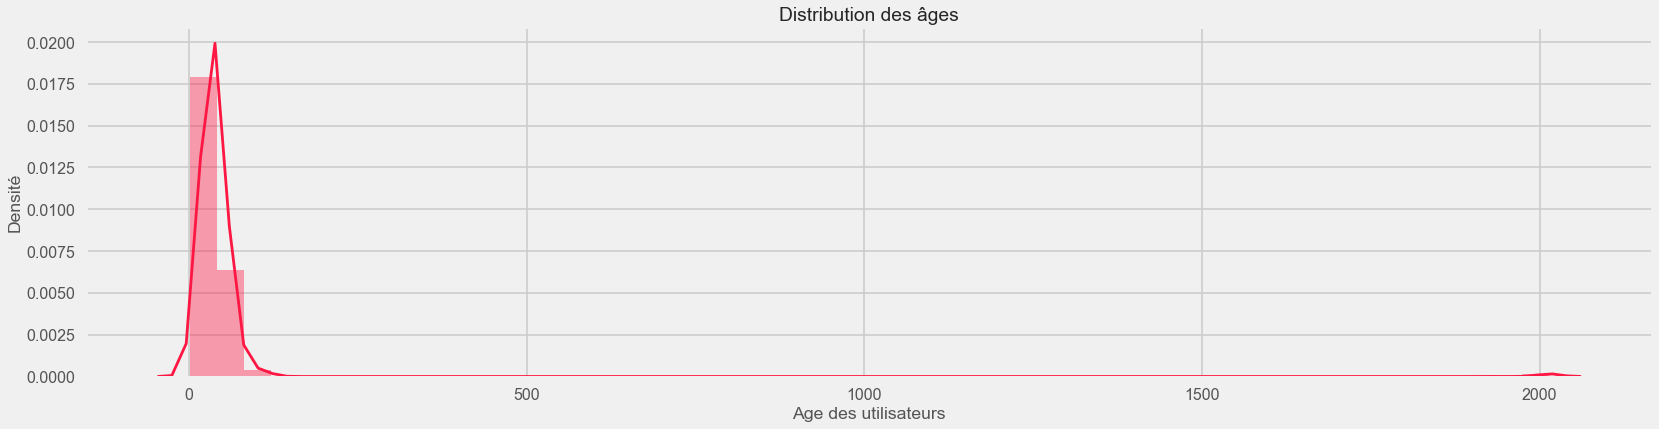

In [120]:
f = plt.figure(figsize=(25, 6))
f.add_subplot(1, 1, 1)
sns.distplot(users['age'], color='#ff1744')
plt.ylabel('Densité')
plt.xlabel('Age des utilisateurs')
_ = plt.title("Distribution des âges")

Ici, on voit clairement que l'âge est erroné (certaines personnes auraient plus de 2000 ans). Il est possible que des individus aient renseignés leur années de naissance à la place de leur âge ou ayant sélectionné l'année par défaut (souvent l'année de la création du compte, aux alentours de 2014).

Text(0.5, 0, 'Age des utilisateurs')

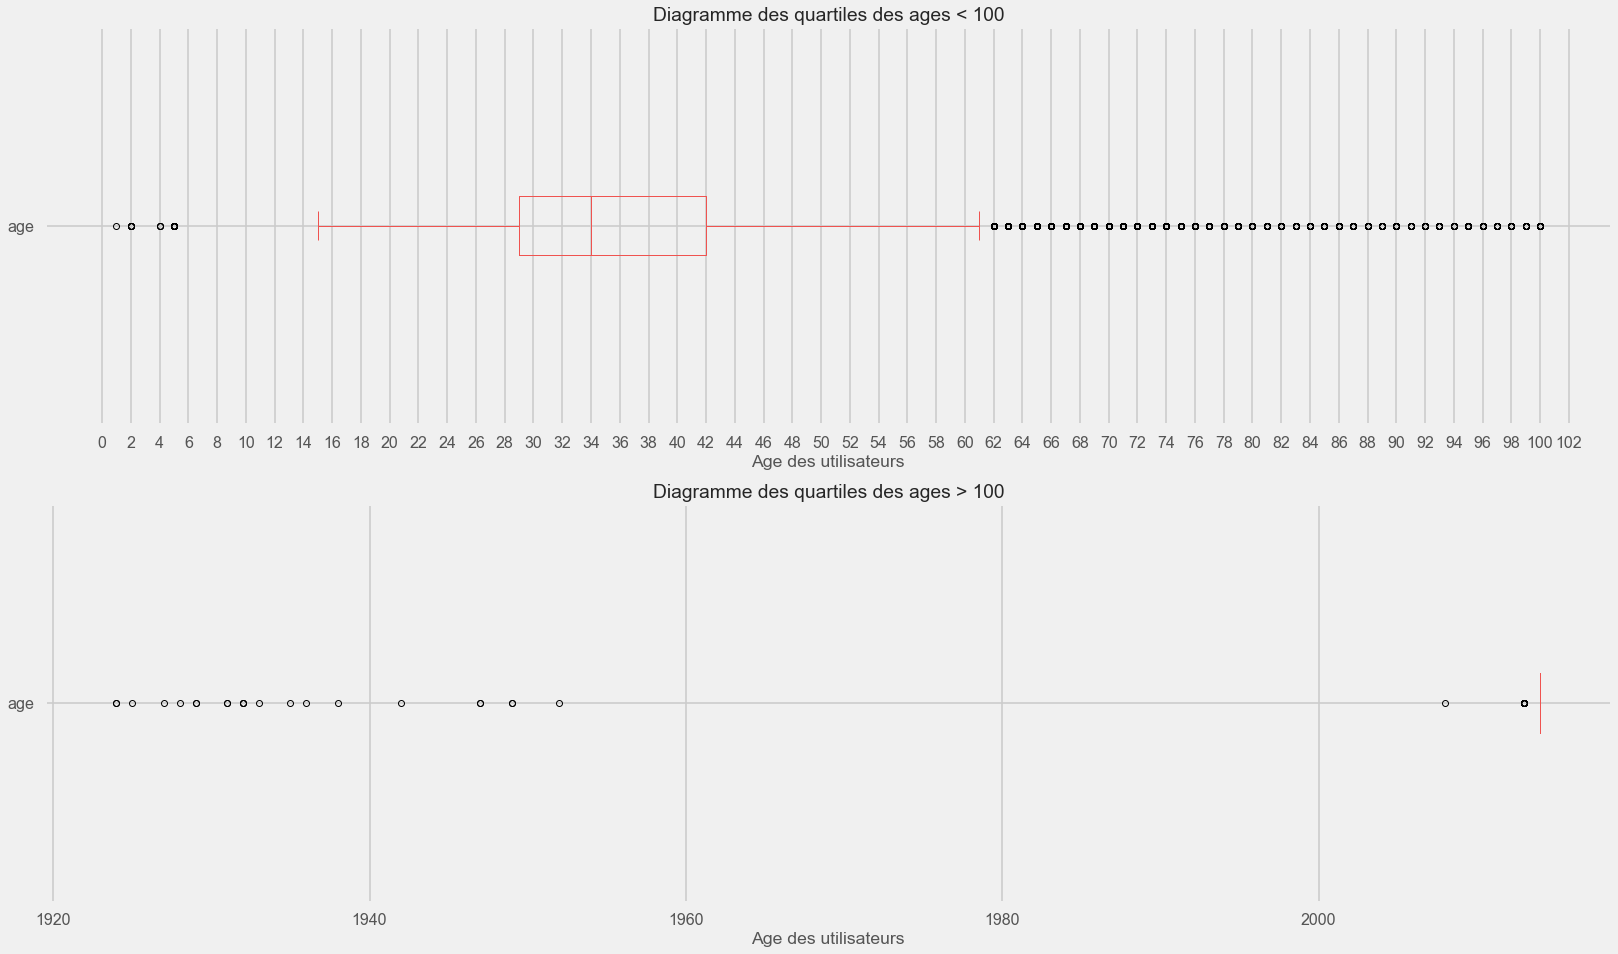

In [167]:
fig, ax = plt.subplots(2, 1, figsize=(25, 15))
users[users['age'] <= 100].boxplot(column=['age'], vert=False, ax=ax[0], color='#ef5350')
ax[0].set_title('Diagramme des quartiles des ages < 100')
ax[0].set_xticks(range(0, 103, 2))
ax[0].set_xlabel('Age des utilisateurs')

users[users['age'] >= 1000].boxplot(column=['age'], vert=False, ax=ax[1], color='#ef5350')
ax[1].set_title('Diagramme des quartiles des ages > 100')
ax[1].set_xlabel('Age des utilisateurs')

* l'âge médian est de 34 ans. 
* un groupe de personnes ont indiqué un âge proche des 2000 ans ; on supposera qu'ils ont confondu l'âge et l'année de naissance.
* un groupe de personnes ont indiqué un âge proche de 2014 ; on supposera qu'ils s'agit de l'année par défaut et (qu'au delà de 2000) ils n'ont donc renseigné aucune valeur.

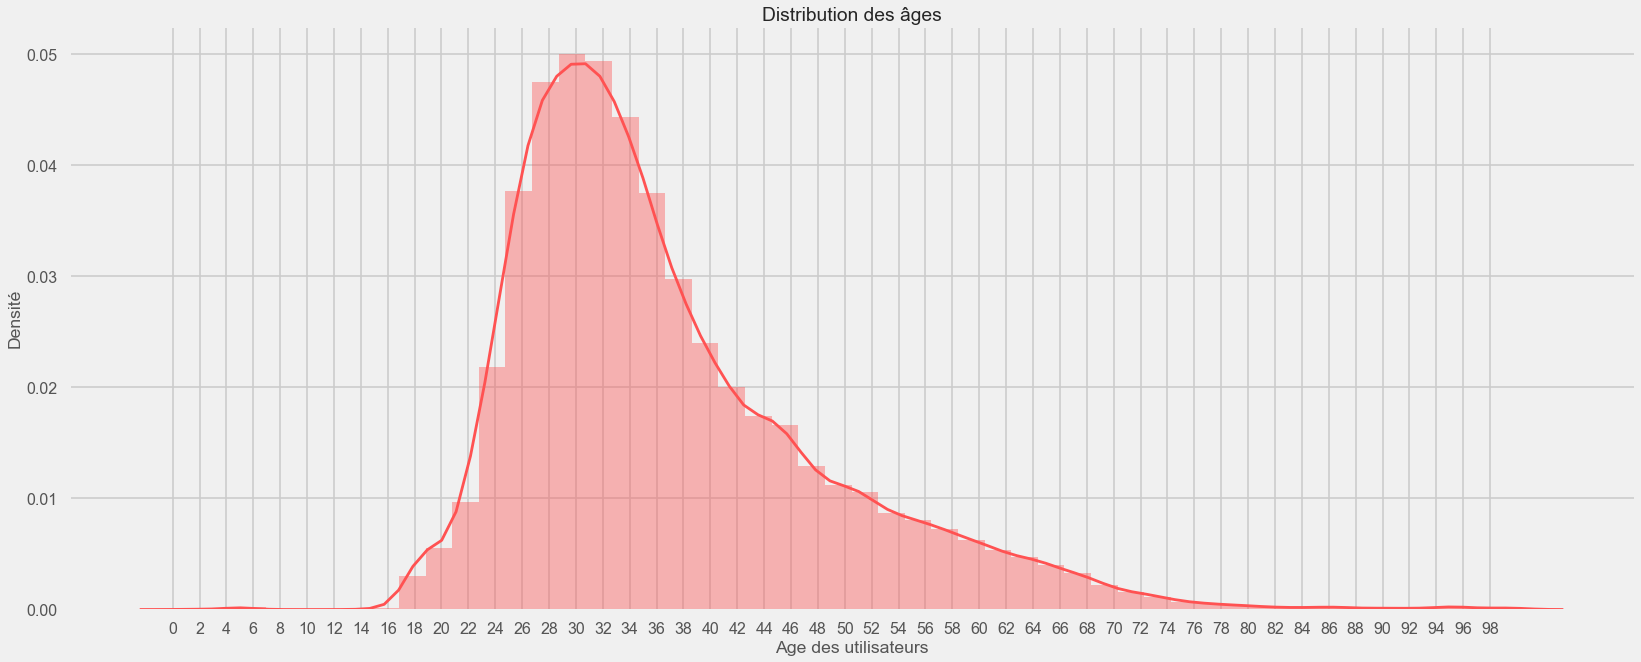

In [122]:
f = plt.figure(figsize=(25, 10))
f.add_subplot(1, 1, 1)
sns.distplot(users[users['age'] <= 100]['age'], color='#ff5252')
plt.ylabel('Densité')
plt.xlabel('Age des utilisateurs')
plt.xticks(range(0, 100, 2))
_ = plt.title("Distribution des âges")

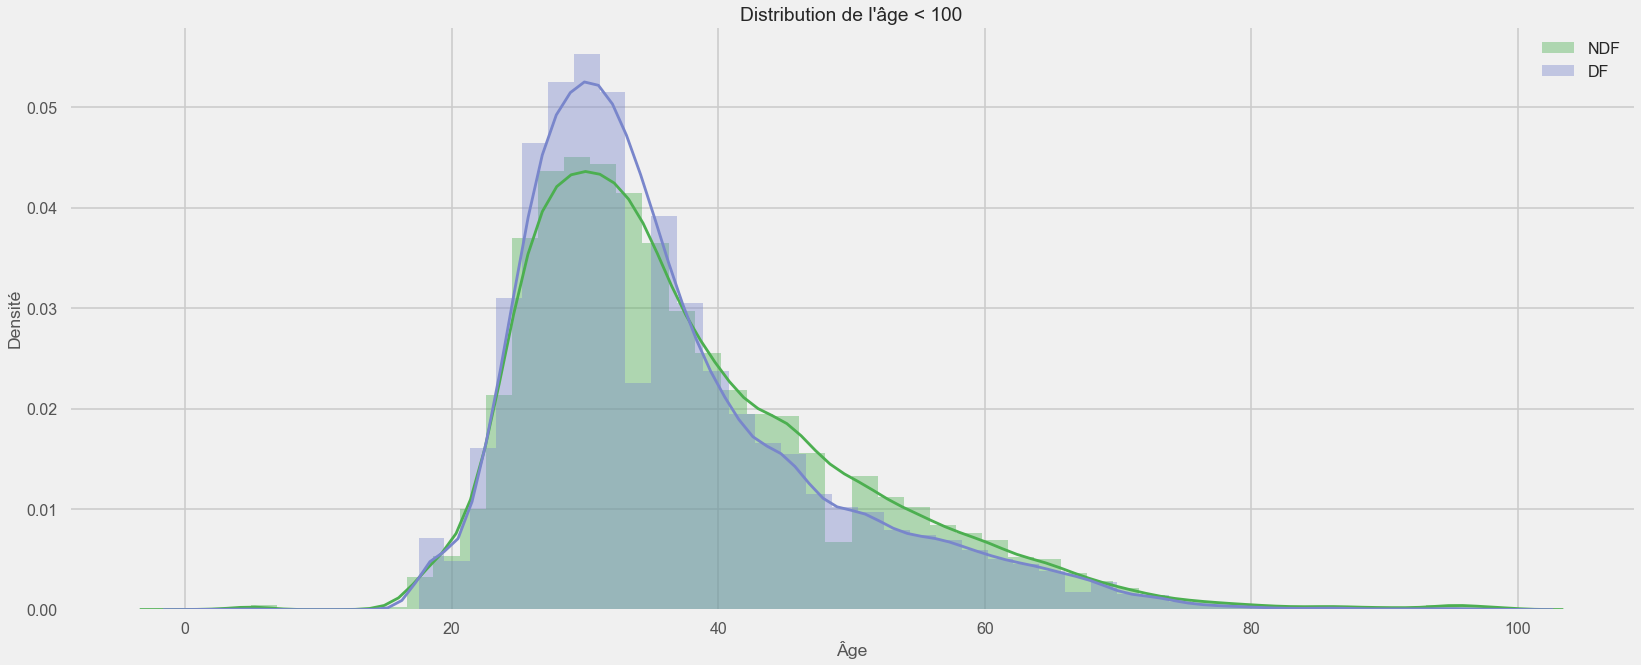

In [123]:
plt.figure(figsize=(25, 10))
sns.distplot(users[(users['destination_found'] == 'NDF') & (users['age'] < 100)]['age'], label='NDF', color='#4caf50')
sns.distplot(users[(users['destination_found'] == 'DF') & (users['age'] < 100)]['age'], label='DF', color='#7986cb')
plt.title("Distribution de l'âge < 100")
plt.ylabel('Densité')
plt.xlabel('Âge')
_ = plt.legend()

* Les individus marqués comme étant DF ont un âge légèrement plus centré vers les 30 ans que ceux marqués comme étant NDF. 
* Ces derniers ont une population qui est légèrement plus importante au niveau des 50 ans. 

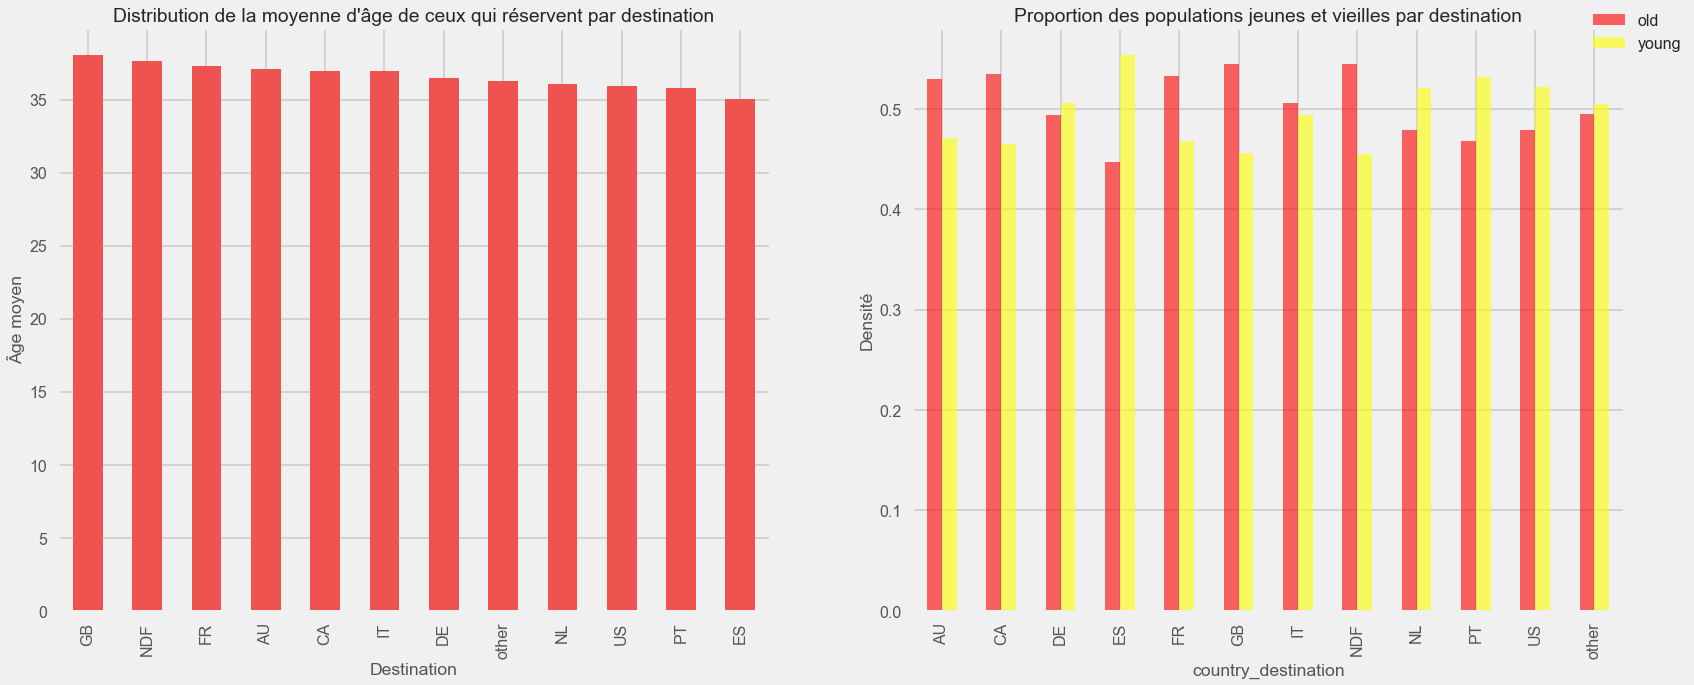

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
destination_ages = users[users['age'] < 100].groupby('country_destination').agg({'age': np.mean})['age'].sort_values(ascending=False)
destination_ages.plot(kind='bar', ax=ax1, color='#ef5350')
ax1.set_ylabel('Âge moyen')
ax1.set_xlabel('Destination')
ax1.set_title("Distribution de la moyenne d'âge de ceux qui réservent par destination")

users['age_category'] = users.apply(lambda r: 'young' if r['age'] < 34 else 'old', axis=1)
var = pd.crosstab(users[users['age'] < 100]['country_destination'], users[users['age'] < 100]['age_category'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='autumn', alpha=.8)
ax2.set_ylabel("Densité")
ax2.set_title("Proportion des populations jeunes et vieilles par destination")
plt.legend(bbox_to_anchor=(1.1, 1.05))
users = users.drop('age_category', axis=1)

On peut voir que : 
* les utilisateurs qui ont effectué une réservation en Grande-Bretagne (GB), France (FR), Canada (CA) ou Australie (AU) ont tendance a être plus âgés que le reste. 
* À l'inverse, les utilisateurs ayant réservé en Espagne (ES), Portugal (PT) ou aux Etats-Unis (US) ont tendance à être plus jeune. 
* Les utilisateurs n'ayant fait de réservation tendent à être plus âgé également. Cela rejoint notre observation sous le graphique précédent.

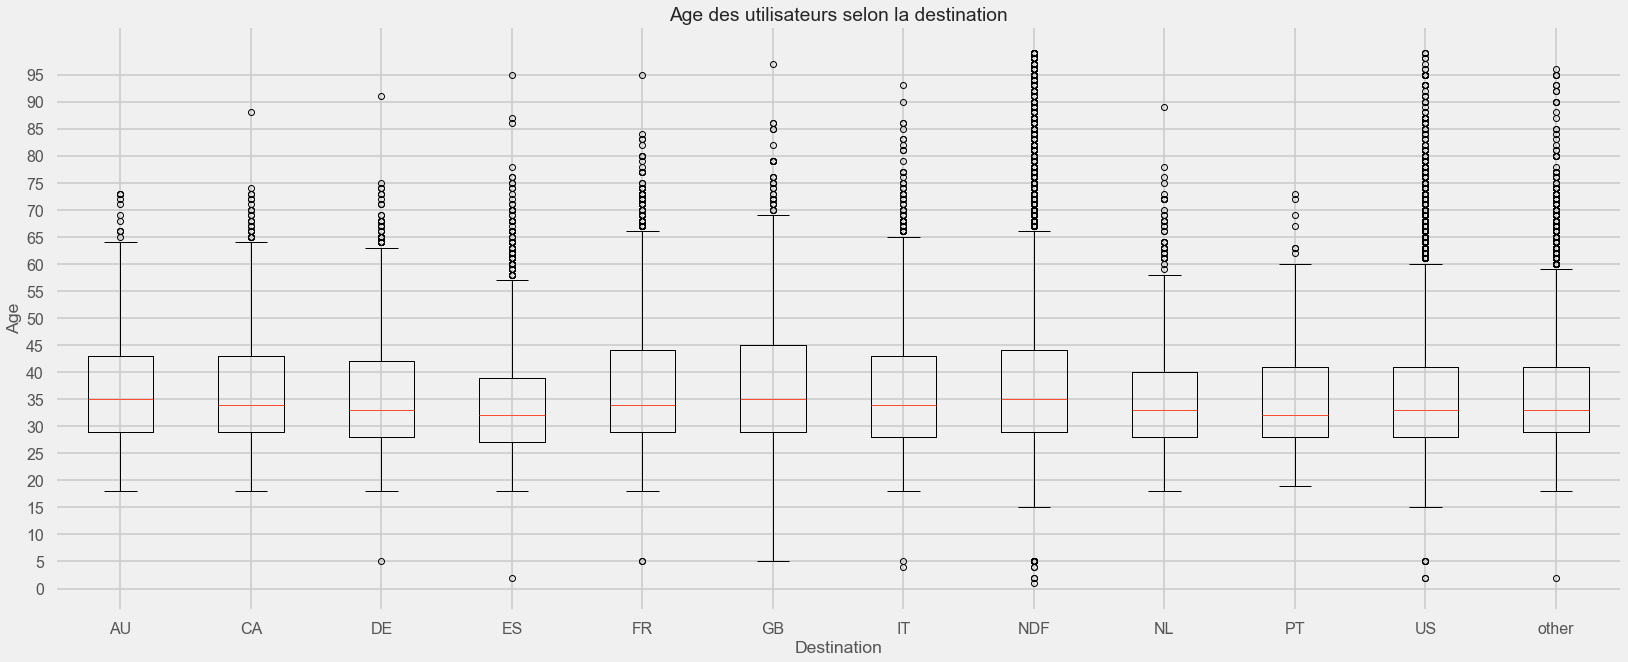

In [125]:
ages = {}
for dest in np.unique(users['country_destination']):
    ages[dest] = users[(users['country_destination'] == dest) & (~users['age'].isnull()) & (users['age'] < 100)]['age'].values
    
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_title("Age des utilisateurs selon la destination")
ax.set_xlabel('Destination')
ax.set_ylabel('Age')
ax.boxplot(ages.values())
ax.set_yticks(list(range(0, 100, 5)))
_ = ax.set_xticklabels(ages.keys())

* L'Espagne, l'Allemagne, les Etats-Unis et le Portugal attirent les populations les plus jeunes avec une médiane de 33 ans.
* La Grande-Bretagne accueille des utilisateurs d'âge très divers.

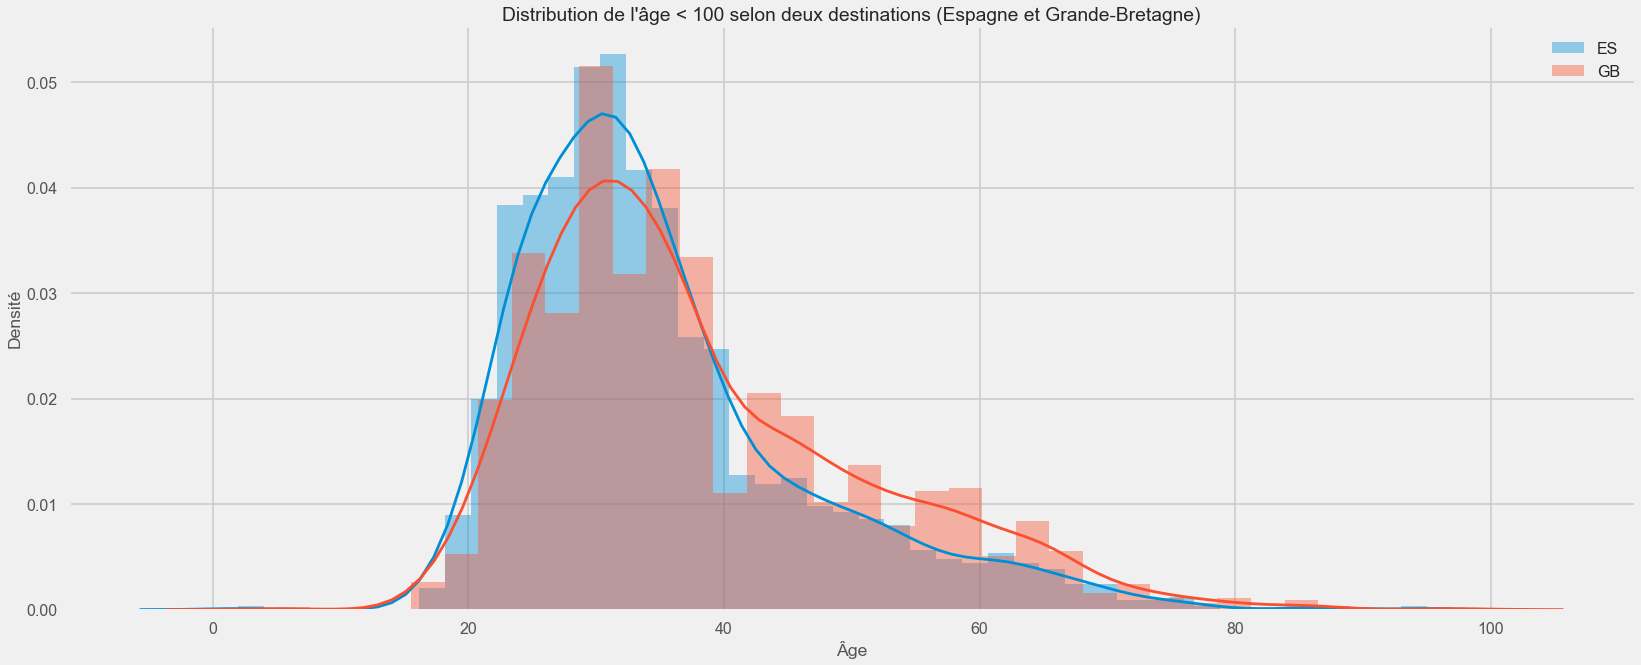

In [126]:
plt.figure(figsize=(25, 10))
sns.distplot(users[(users['country_destination'] == 'ES') & (users['age'] < 100)]['age'], label='ES')
sns.distplot(users[(users['country_destination'] == 'GB') & (users['age'] < 100)]['age'], label='GB')
plt.ylabel('Densité')
plt.xlabel('Âge')
plt.title("Distribution de l'âge < 100 selon deux destinations (Espagne et Grande-Bretagne)")
_ = plt.legend()

Cependant, en mettant en contraste les pays extrêmes, on voit que la population des 40 à 70 ans est légèrement plus importante parmi ceux ayant réservé en Grande-Bretagne (GB) qu'en Espagne. Ceux ayant fait une réservation en Espagne ont une population plus importante dans la tranche d'âges [20, 25]. Les tranches d'âges citées ici seront utiles pour catégoriser l'âge des individus. En effet, il serait intéressant de créer des groupes par tranche d'âge ; notament [20, 25] et [40, 70] par exemple afin de mieux séparer nos indvidus.

Néanmoins, les données restent peu séparables dans ce cas.

Etudions les cas où les ages sont erronés. On peut s'attendre à ce qu'il y ait une plus grande proportion de NDF ici, dans l'éventualité qu'un profil incomplet ou erroné un refus de réservation.

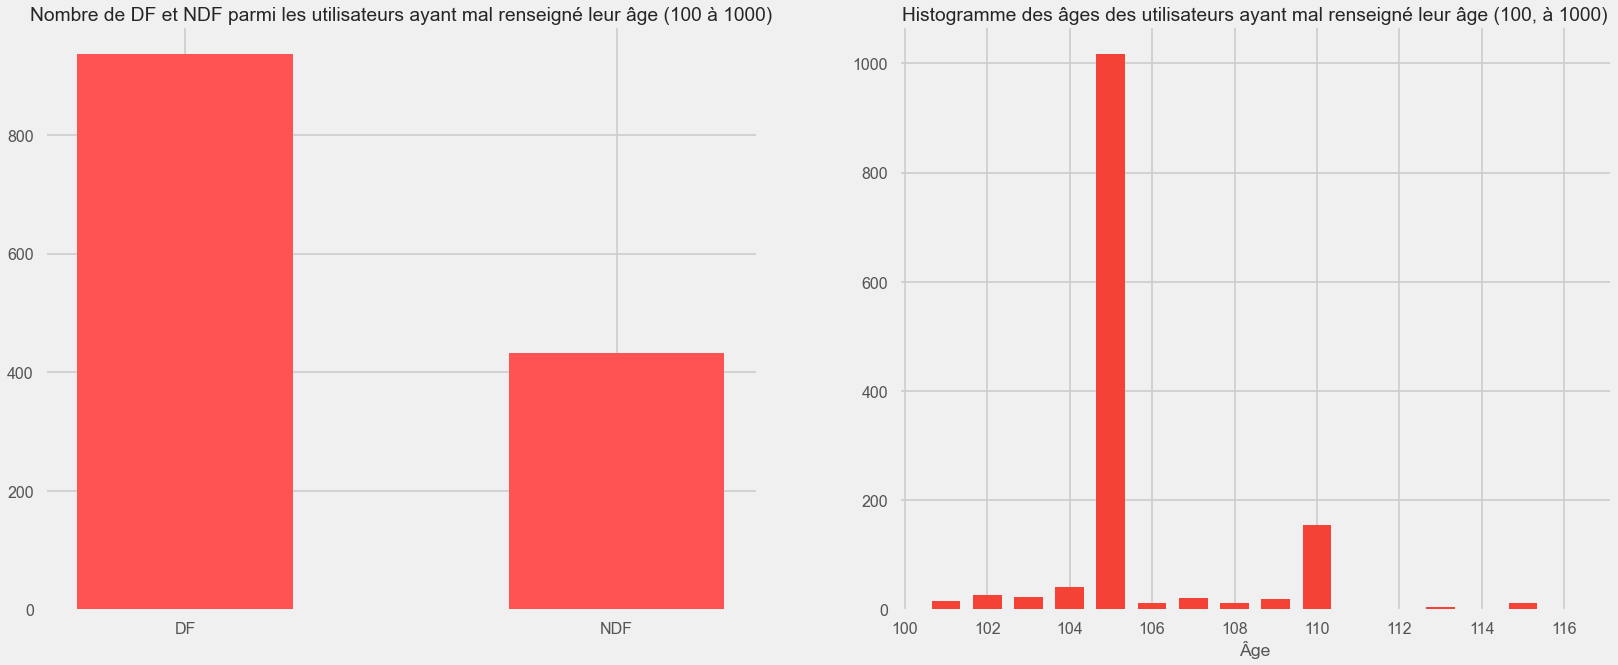

In [127]:
users100 = users[(users['age'] > 100) & (users['age'] < 1000)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
users100['destination_found'].hist(bins=np.arange(3)-0.5, rwidth=0.5, figsize=(25, 10), ax=ax1, color='#ff5252')
ax1.set_title('Nombre de DF et NDF parmi les utilisateurs ayant mal renseigné leur âge (100 à 1000)')
ax2.set_title('Histogramme des âges des utilisateurs ayant mal renseigné leur âge (100, à 1000)')
ax2.set_xlabel('Âge')
_ = users100['age'].hist(ax=ax2, rwidth=0.7, bins=np.arange(users100['age'].nunique()+1)-0.5 + users100['age'].min(), color='#f44336')

On observe l'effet inserve, à savoir qu'il y a plus de DF que de NDF parmi les utilisateurs avec un âge erroné. Etrangement, l'âge 105 est très représenté.

Text(0.5, 0, 'Age des utilisateurs')

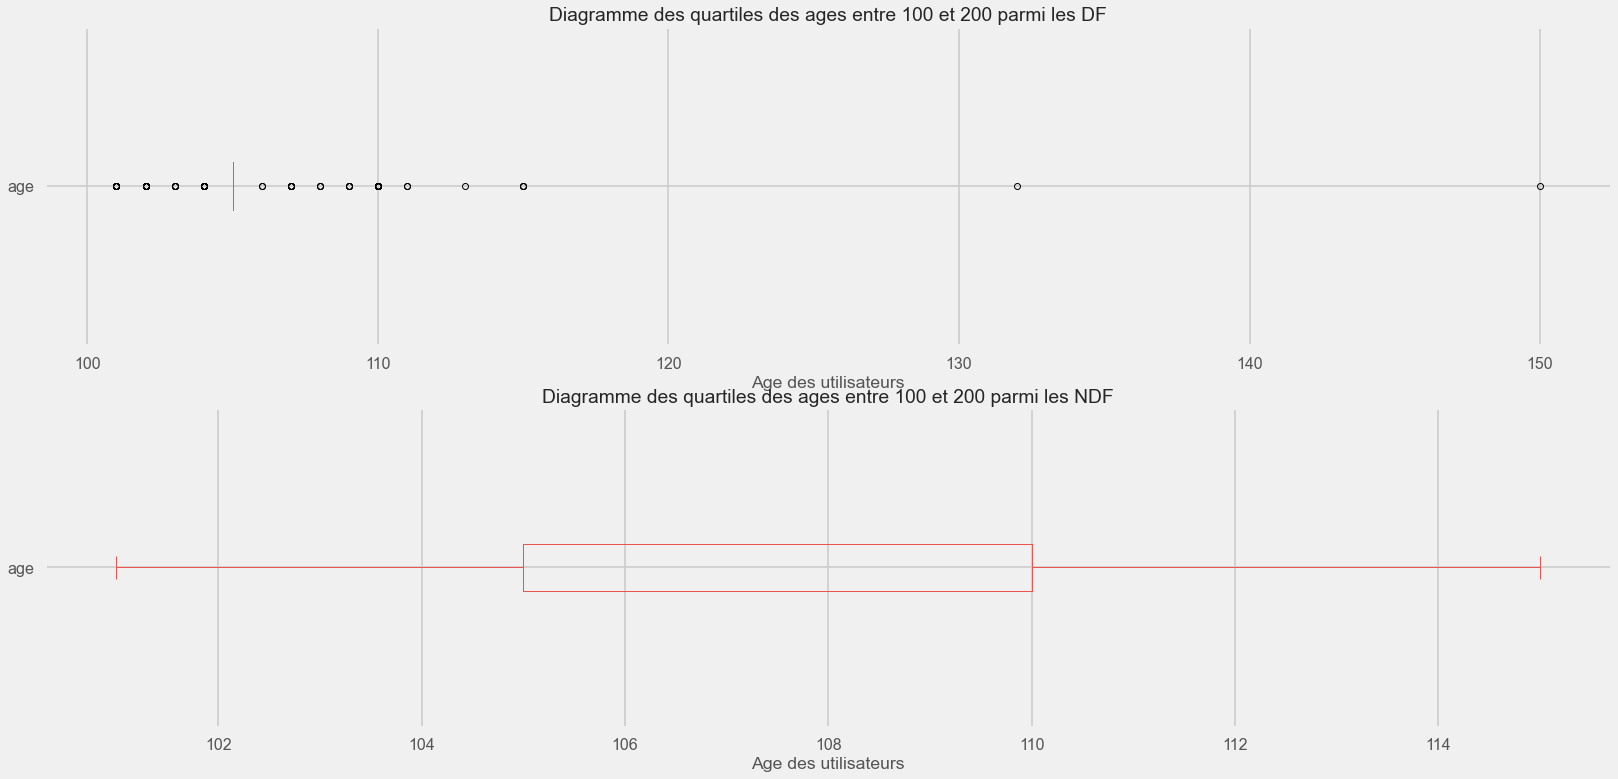

In [128]:
fig, ax = plt.subplots(2, 1, figsize=(25, 12))
users[(users['age'] > 100) & (users['age'] < 1000) & (users['destination_found'] == 'DF')].boxplot(column=['age'], vert=False, ax=ax[0], color='#ef5350')
ax[0].set_title('Diagramme des quartiles des ages entre 100 et 200 parmi les DF')
ax[0].set_xlabel('Age des utilisateurs')

users[(users['age'] > 100) & (users['age'] < 1000) & (users['destination_found'] == 'NDF')].boxplot(column=['age'], vert=False, ax=ax[1], color='#ef5350')
ax[1].set_title('Diagramme des quartiles des ages entre 100 et 200 parmi les NDF')
ax[1].set_xlabel('Age des utilisateurs')

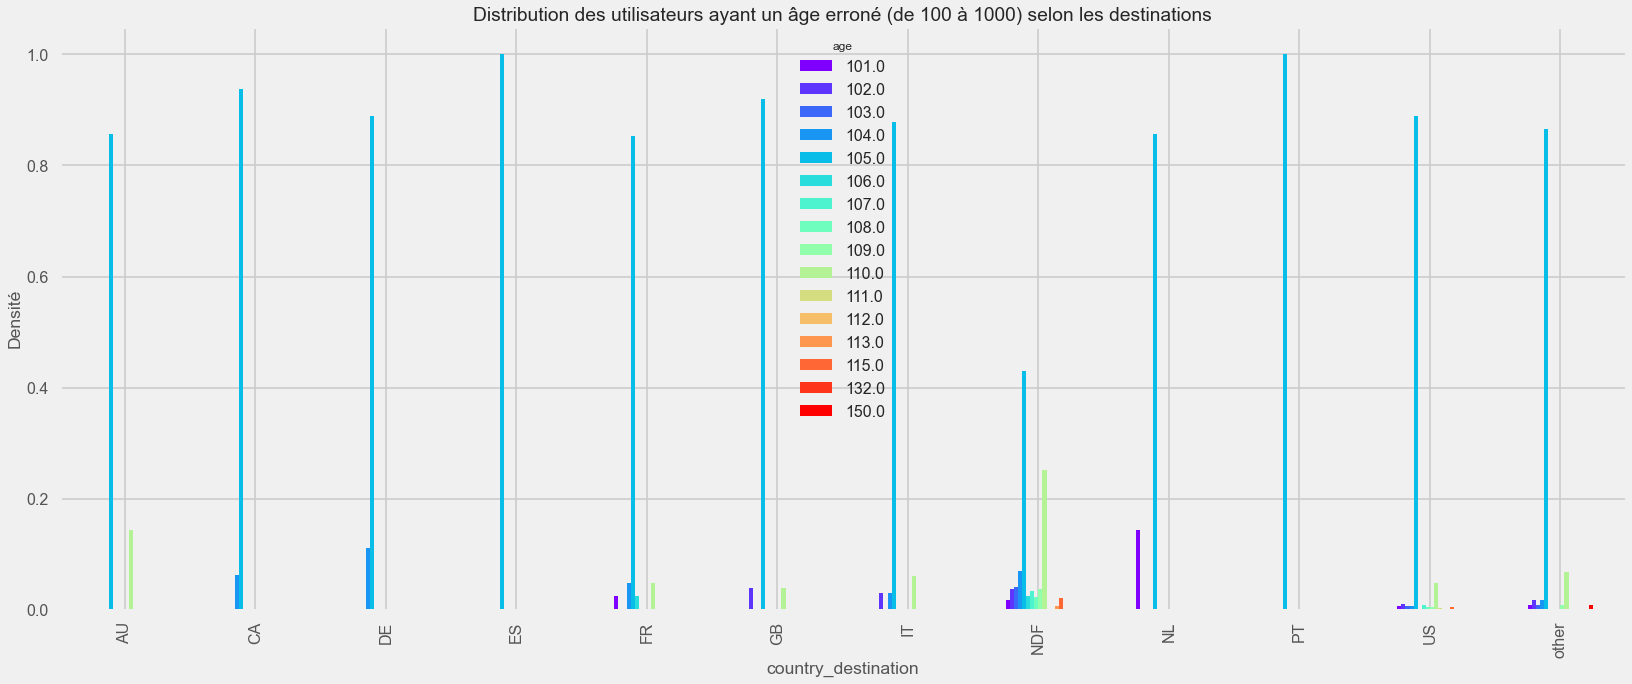

In [129]:
colors = cm.rainbow(np.linspace(0,1,users100['age'].nunique()))
var = pd.crosstab(users100['country_destination'], users100['age'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, color=colors, figsize=(25, 10))
plt.title('Distribution des utilisateurs ayant un âge erroné (de 100 à 1000) selon les destinations')
_ = plt.ylabel('Densité')

Ce graphique montre clairement que l'âge 105 est responsable du phénomène observé au dessus, à savoir un taux de DF plus élevé que les NDF parmi ceux ayant un âge entre 100 et 1000.

### Signup_method

On va s'intéresser à la manière dont l'utilisateur s'est inscrit / se connecte.

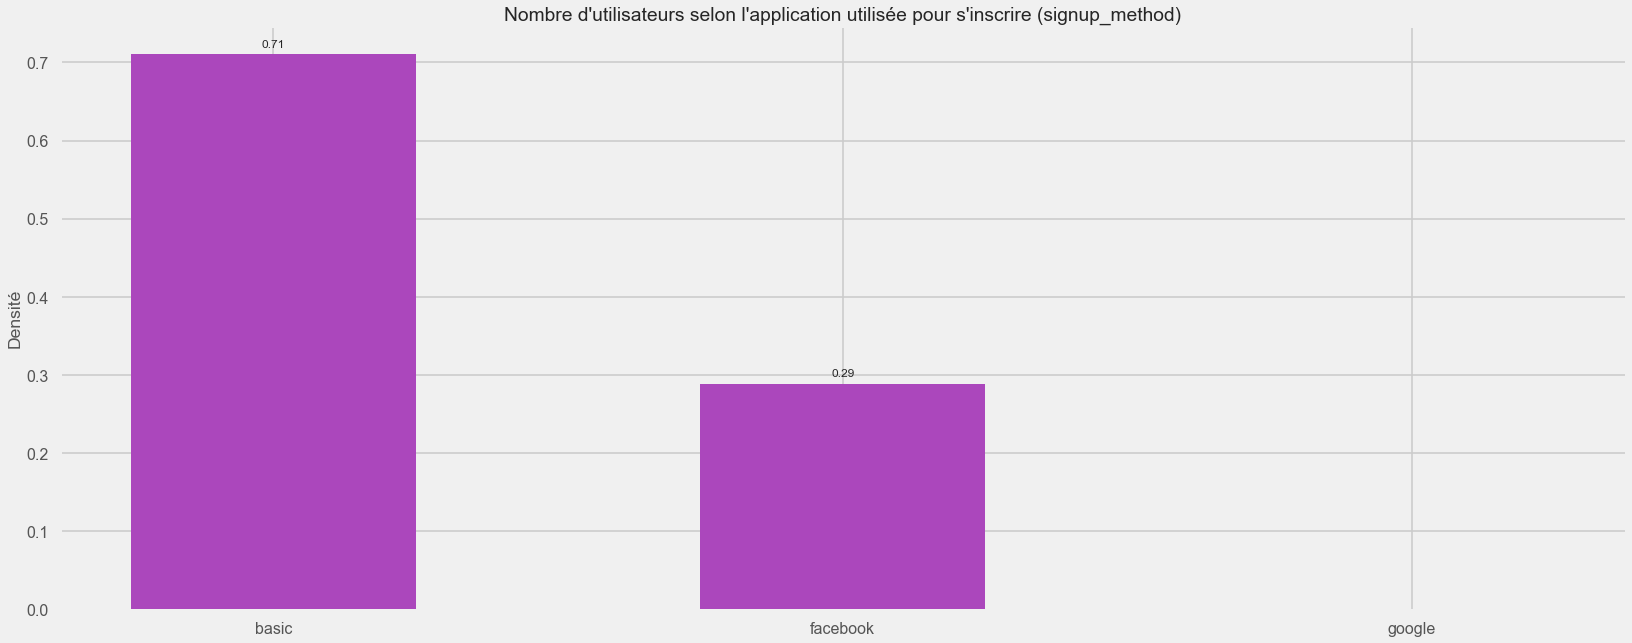

In [130]:
ax = users['signup_method'].hist(figsize=(25, 10), rwidth=0.5, bins=np.arange(4)-0.5, color='#ab47bc', density=True)
ax.set_title("Nombre d'utilisateurs selon l'application utilisée pour s'inscrire (signup_method)")
ax.set_ylabel('Densité')
autolabel(ax.patches, ax)

* 71% des utilisateurs se sont inscrits via le site d'Airbnb. 
* 29% se connecte depuis Facebook
* Une minorité depuis Google. Ces derniers sont en réalité constitués que de 98 utilisateurs, ce qui est très faible comparé aux 176000 utilisateurs étudiés.

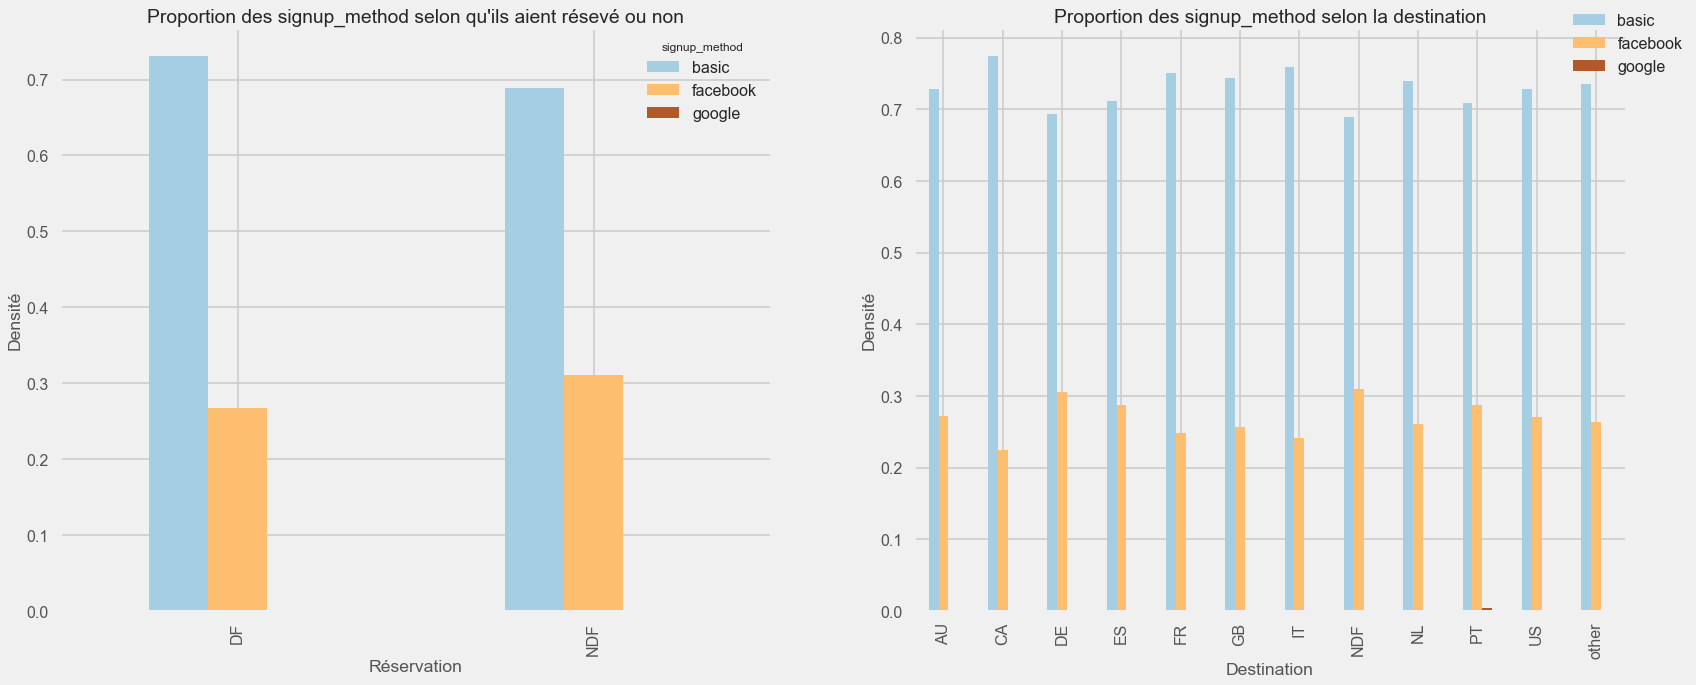

In [131]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
var = pd.crosstab(users['destination_found'], users['signup_method'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='Paired')
ax1.set_title("Proportion des signup_method selon qu'ils aient résevé ou non")
ax1.set_ylabel("Densité")
ax1.set_xlabel('Réservation')

var = pd.crosstab(users['country_destination'], users['signup_method'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='Paired')
plt.legend(bbox_to_anchor=(1.1, 1.05))
ax2.set_ylabel("Densité")
ax2.set_xlabel('Destination')
_ = ax2.set_title("Proportion des signup_method selon la destination")

* On peut distinguer une légère tendence à s'incrire directement depuis le site d'Airbnb ou Google parmi les DF alors que les NDF ont une tendance pour Facebook.
* 100% des utlisateurs inscrit à partir de Google sont des DF.

### Signup_flow

Il s'agit du numéro de la page à partir duquel l'utilisateur à décider de s'inscrire.

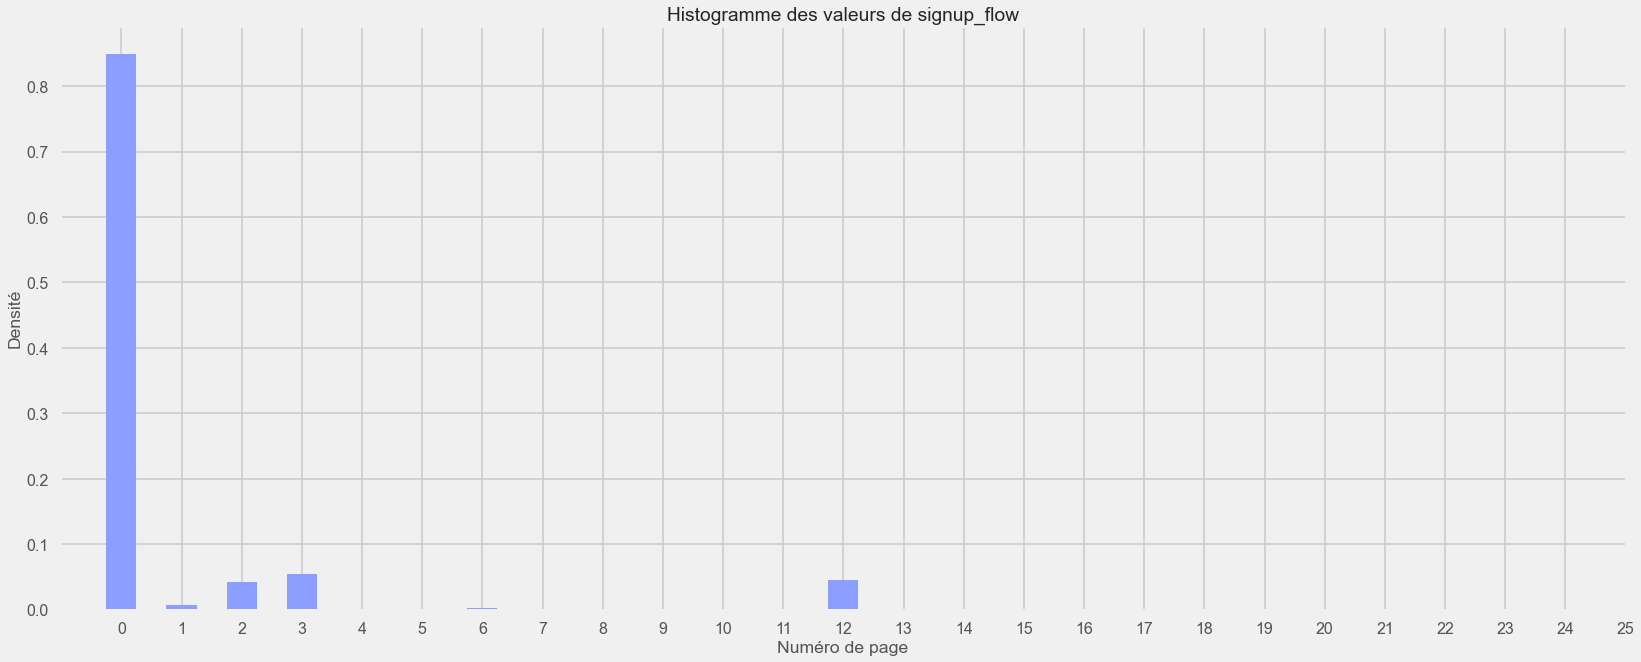

In [132]:
ax = users['signup_flow'].hist(bins=np.arange(users['signup_flow'].nunique())-0.5, rwidth=0.5, figsize=(25, 10), density=True, color='#8c9eff')
ax.set_title("Histogramme des valeurs de signup_flow")
ax.set_xlabel('Numéro de page')
ax.set_ylabel('Densité')
_ = plt.xticks(range(0, 26))

On voit que : 
* la grande majorité des individus se sont inscrits dès la page 0 (page d'accueil). 
* les autres pages les plus fréquentes sont les pages 2, 3 et 12. Il est probable que l'utilisateur ait trouvé un logement intéressant et a donc décidé de s'inscrire à cet instant. 

Néanmoins, ce pic à la page 12 reste assez étrange. Il est possible qu'il s'agisse de la dernière page de recherche dans la majorité des cas. Les pages suivantes n'existeraient que dans quelques rares destinations. Ceux ayant atteints la page 12 n'ont peut être pas l'intention de trouver un logement mais seulement regarder ce qui est proposé.

Affichons les histogrammes par classes et destinations afin de vérifier l'hypothèse. La valeur 0 du signup_flow a été volontairement retirée dans le graphique de droite car les proportions étaient très similiares d'une destination à l'autre et également très importante ce qui réduisait la visibilité des autre valeurs du signup_flow.

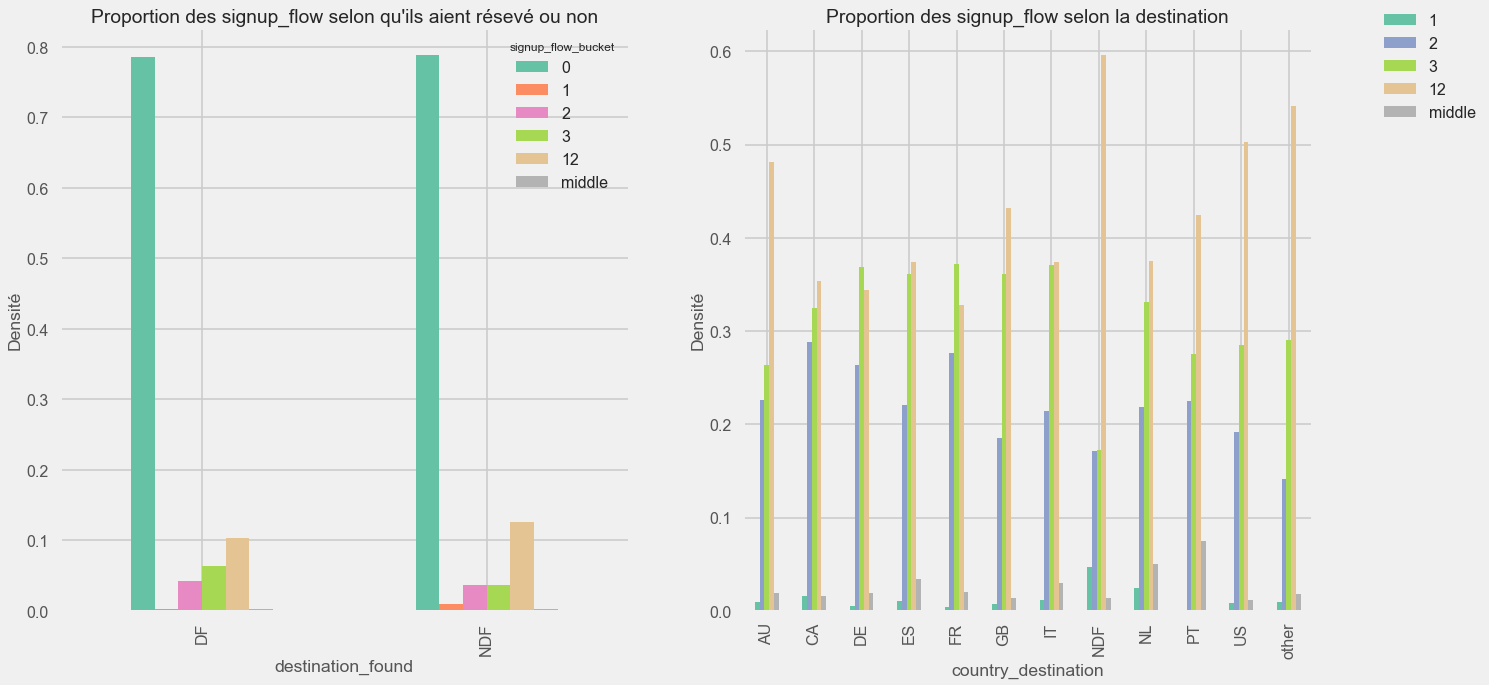

In [133]:
def process_signup_flow(num_page):
    if num_page <= 3:
        return num_page
    elif 3 < num_page < 12:
        return 'middle'
    else:
        return 12
users['signup_flow_bucket'] = users.apply(lambda r: process_signup_flow(r['signup_flow']), axis=1)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
var = pd.crosstab(users['destination_found'], users['signup_flow_bucket'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='Set2')
ax1.set_title("Proportion des signup_flow selon qu'ils aient résevé ou non")
ax1.set_ylabel('Densité')

var = pd.crosstab(users[users['signup_flow_bucket'] != 0]['country_destination'], users[users['signup_flow_bucket'] != 0]['signup_flow_bucket'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='Set2')
plt.legend(bbox_to_anchor=(1.1, 1.05))
ax2.set_title("Proportion des signup_flow selon la destination")
ax2.set_ylabel('Densité')
users = users.drop('signup_flow_bucket', axis=1)

On voit bien que ceux qui se sont inscrit dés la 2e ou 3e page ont tendance à effectuer une réservation tandis que ceux qui ont atteint la page 12 (voir les pages supérieures) ont tendance à ne pas réserver ce qui valide notre hypothèse précédente. Pour les autres pages, les proportions semblent identiques d'une classe à l'autre.

Au niveau des différentes destinations :
* la proportion des personnes ayant atteint la page 12 est plus forte pour ceux qui réservent au Etats-Unis (US), Australie (AU), Grande-Bretagne (GB), Portugal (PT) et les autres pays non recensés (other).
* ceux des pages 4 à 11 (middle) ont tendance à réserver au Portugal (PT), Espagne (ES) et aux Pays-Bas (NL).
* ceux de la page 2 ont tendance à réserver au Canada (CA) ou en France (FR) mais peu en Grande-Bretagne (GB) et dans les autres pays non recensés (other).
* ceux de la page 3 apparaissent souvent pour les classes (CA), (DE), (ES), (GB), (IT), (NL) mais peu pour les autres classes. On obtient ainsi deux groupes.

### Language

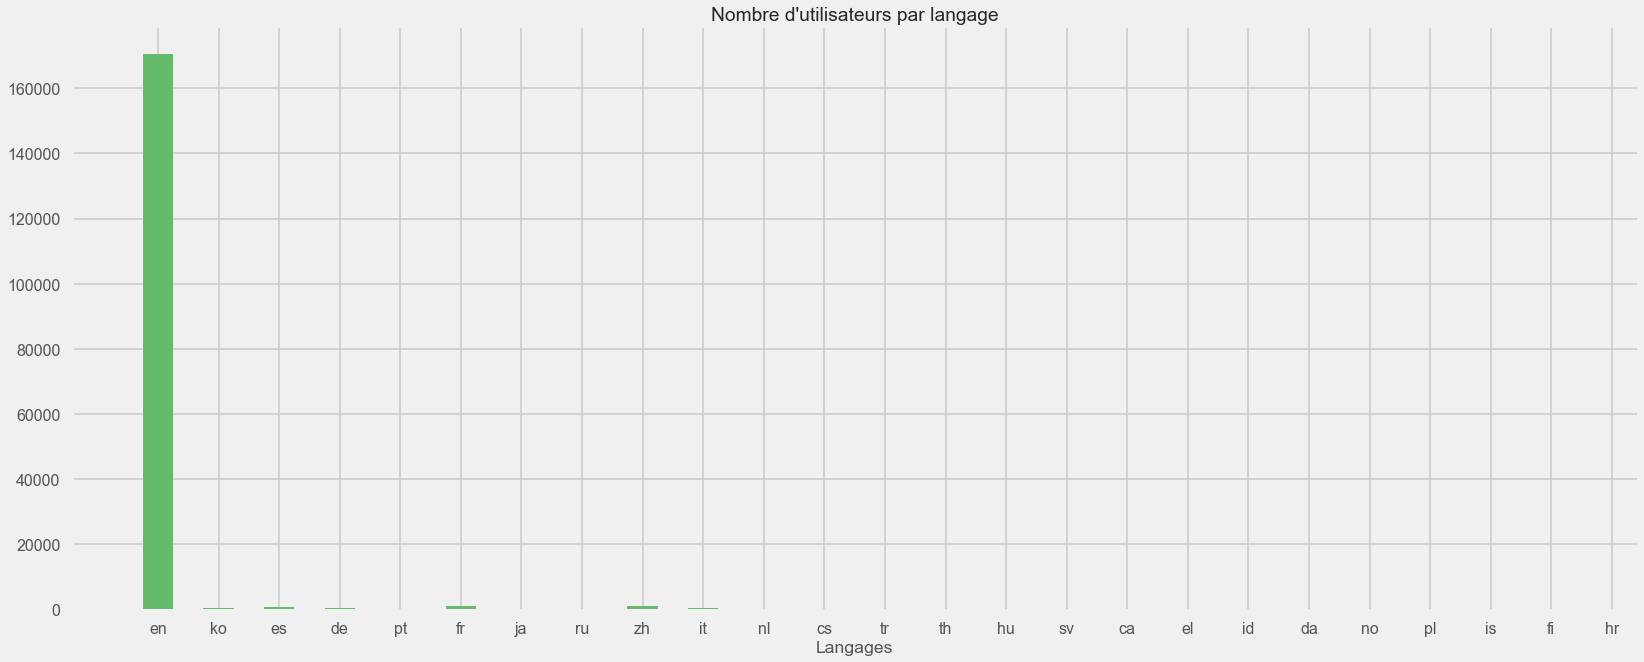

In [134]:
ax = users['language'].hist(bins=np.arange(users['language'].nunique())-0.5, rwidth=0.5, figsize=(25, 10), color='#66bb6a')
ax.set_xlabel('Langages')
_ = ax.set_title("Nombre d'utilisateurs par langage")

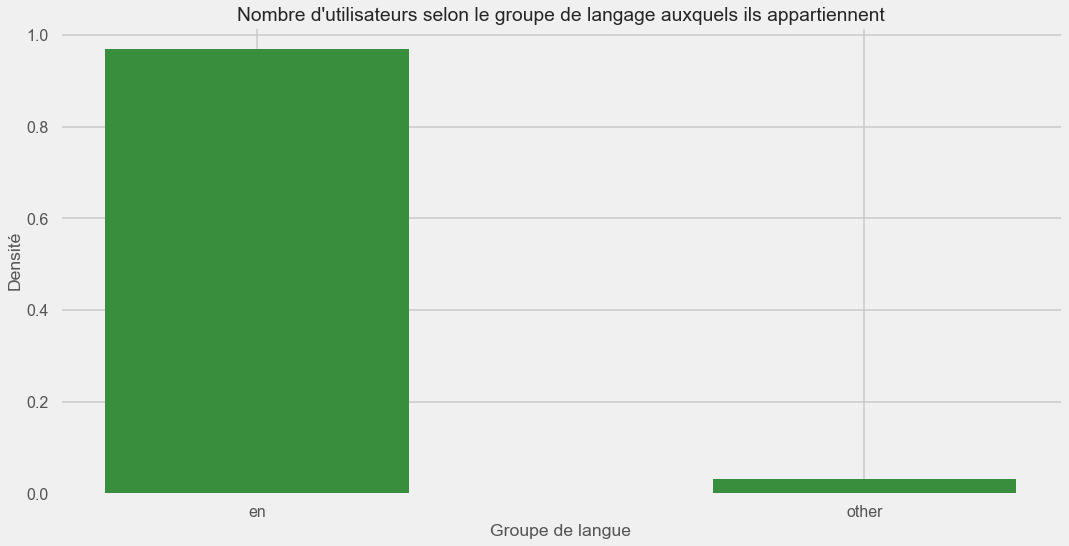

In [135]:
users['language_group'] = users.apply(lambda r: 'en' if r['language'] == 'en' else 'other', axis=1)
ax = users['language_group'].hist(bins=np.arange(3)-0.5, rwidth=0.5, figsize=(16, 8), color='#388e3c', density=True)
ax.set_title("Nombre d'utilisateurs selon le groupe de langage auxquels ils appartiennent")
ax.set_ylabel('Densité')
ax.set_xlabel('Groupe de langue')
users = users.drop('language_group', axis=1)

* La langue majoritairement détectée est l'anglais (en) ce qui est attendu puisque les utilisateurs proviennent des Etats-Unis (à plus de 99%). 
* Le reste des langues est très faiblement représenté (moins de 1%).

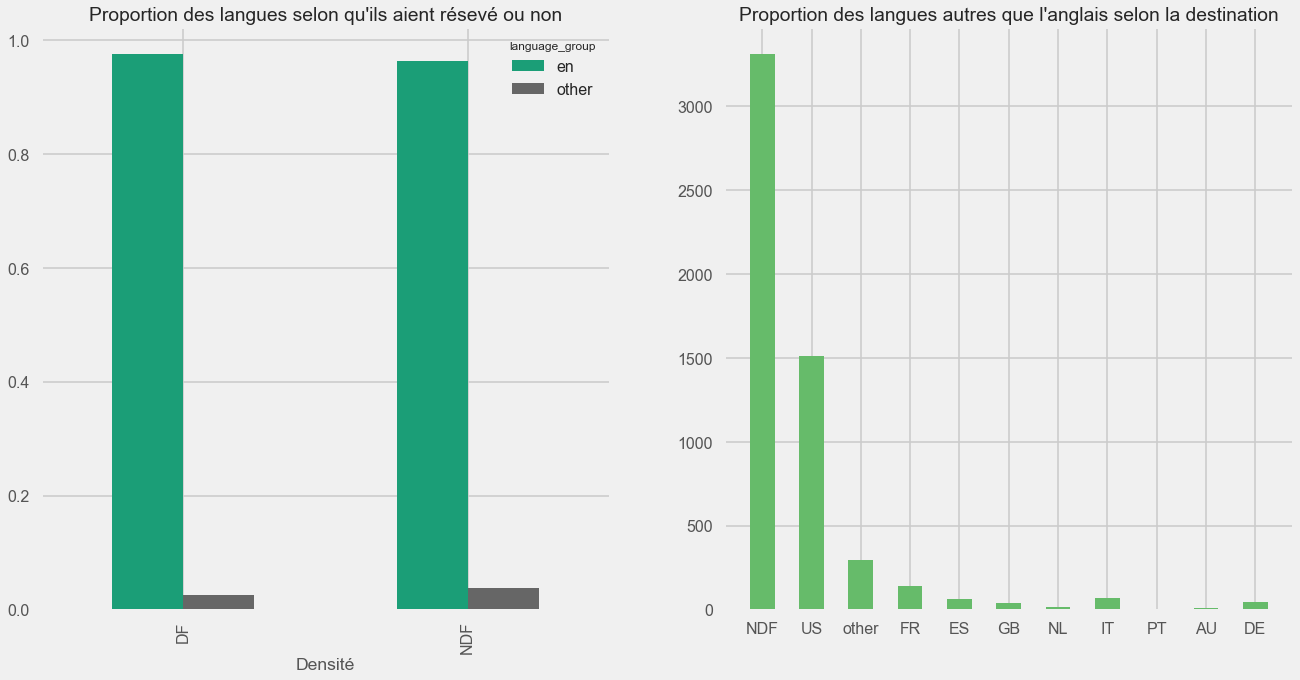

In [136]:
users['language_group'] = users.apply(lambda r: 'en' if r['language'] == 'en' else 'other', axis=1)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
var = pd.crosstab(users['destination_found'], users['language_group'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='Dark2')
ax1.set_title("Proportion des langues selon qu'ils aient résevé ou non")
ax1.set_xlabel('Densité')

plt.hist(users[users['language_group'] == 'other']['country_destination'], bins=np.arange(users['country_destination'].nunique())-0.5, rwidth=0.5, color='#66bb6a')
_ = ax2.set_title("Proportion des langues autres que l'anglais selon la destination")
users = users.drop('language_group', axis=1)

On voit que : 
* ceux employant une autre langue que l'anglais ont une légère tendance à ne pas réserver. Parmi ces derniers, ceux qui effectue tout de même une réservation se tourne majoritairement vers les Etats-Unis (US).
* On distingue également une proportion plus élevée que les autres parmi ceux réservant en France (FR) ou dans les pays non recensés (other).

Affichons les différents languages par pays (sans compter l'anglais).

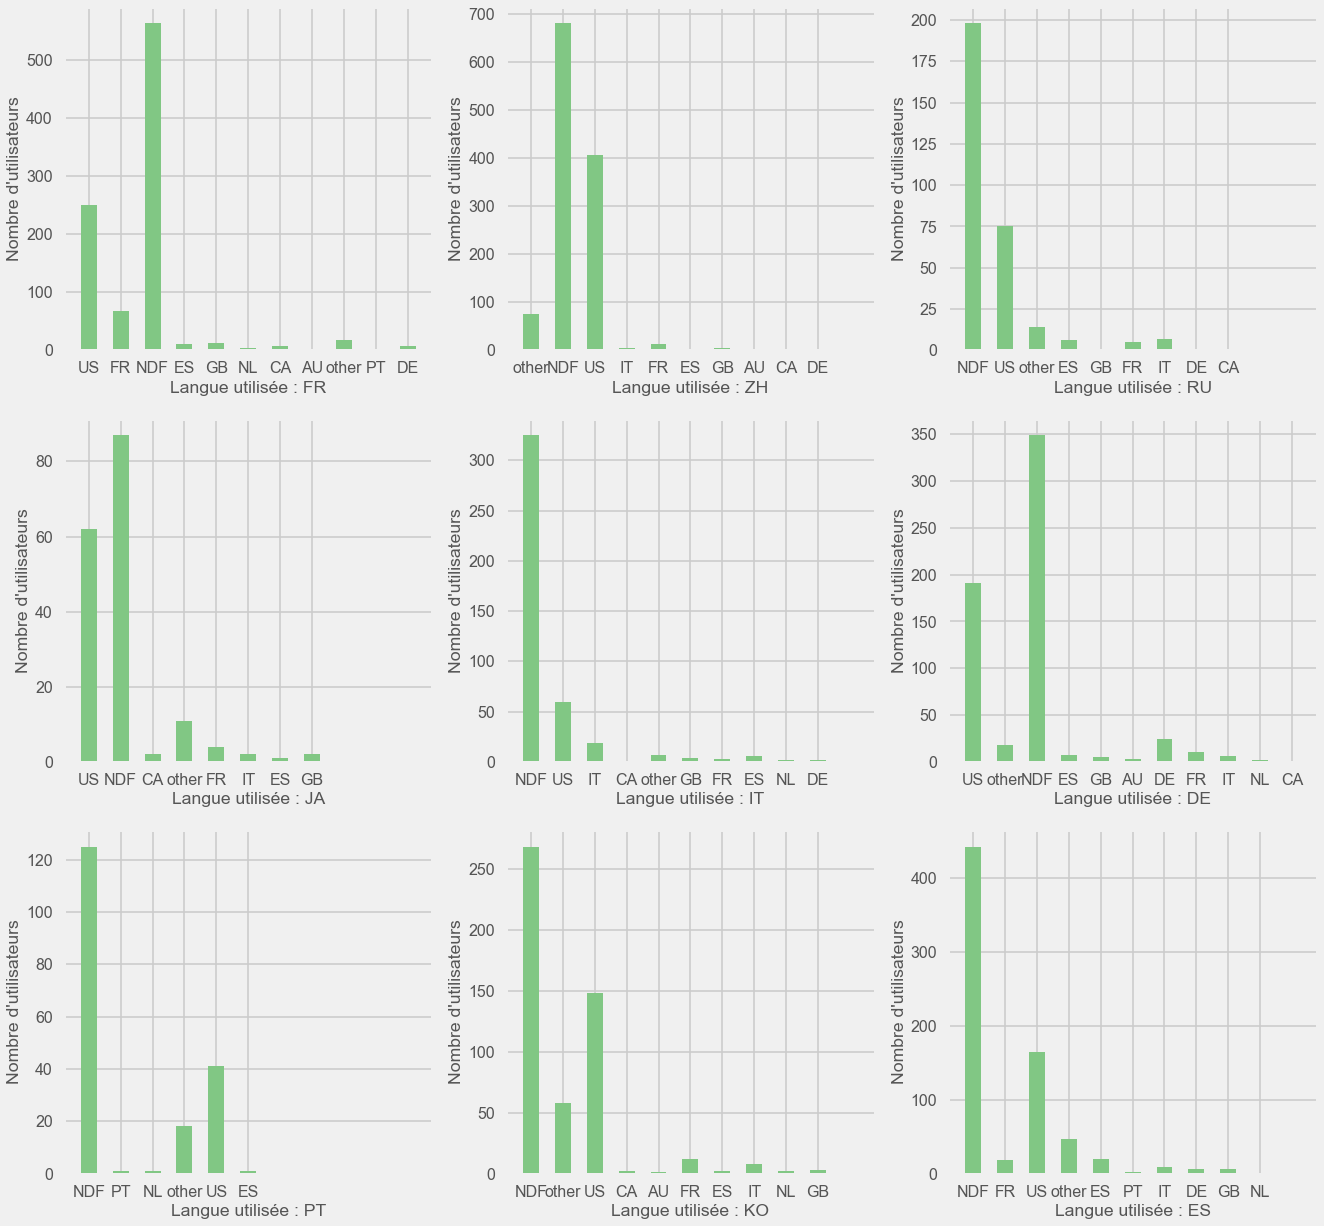

In [137]:
languages = ['fr', 'zh', 'ru', 'ja', 'it', 'de', 'pt', 'ko', 'es']
f = plt.figure(figsize=(20, 20))
for i, language in enumerate(languages):
    f.add_subplot(3, 3, i+1)
    plt.hist(users[users['language'] == language]['country_destination'], bins=np.arange(users['country_destination'].nunique())-0.5, rwidth=0.5, color='#81c784')
    plt.xlabel('Langue utilisée : ' + language.upper())
    plt.ylabel("Nombre d'utilisateurs")

On voit que :
* pour chaque langage, la classe NDF est majoritaire suivie des Etats-Unis (US).
* la troisième destination est très souvent le pays où le langage en est la langue maternelle (par exemple, une partie de ceux qui employe le français réverse en France). Le Portugal et l'Espagne semblent y faire exception. En effet, la classe "other" y prend la 3e position des destinations les plus réservées par ces derniers. Cela n'est pas étrange si on pense aux autres pays de langue portugaise ou espagnol comme le Brésil et le Chili qui ne figurent pas directement parmi les destinations mais rentrent dans la catégorie "other".

### Affiliate_channel

On va étudier la méthode/le canal utilisé pour la campagne d'affiliation par laquel l'utilisateur est arrivé. Cette variable ne concerne pas les informations propres des utilisateurs mais pluôt le processus de marketing employé par Airbnb.

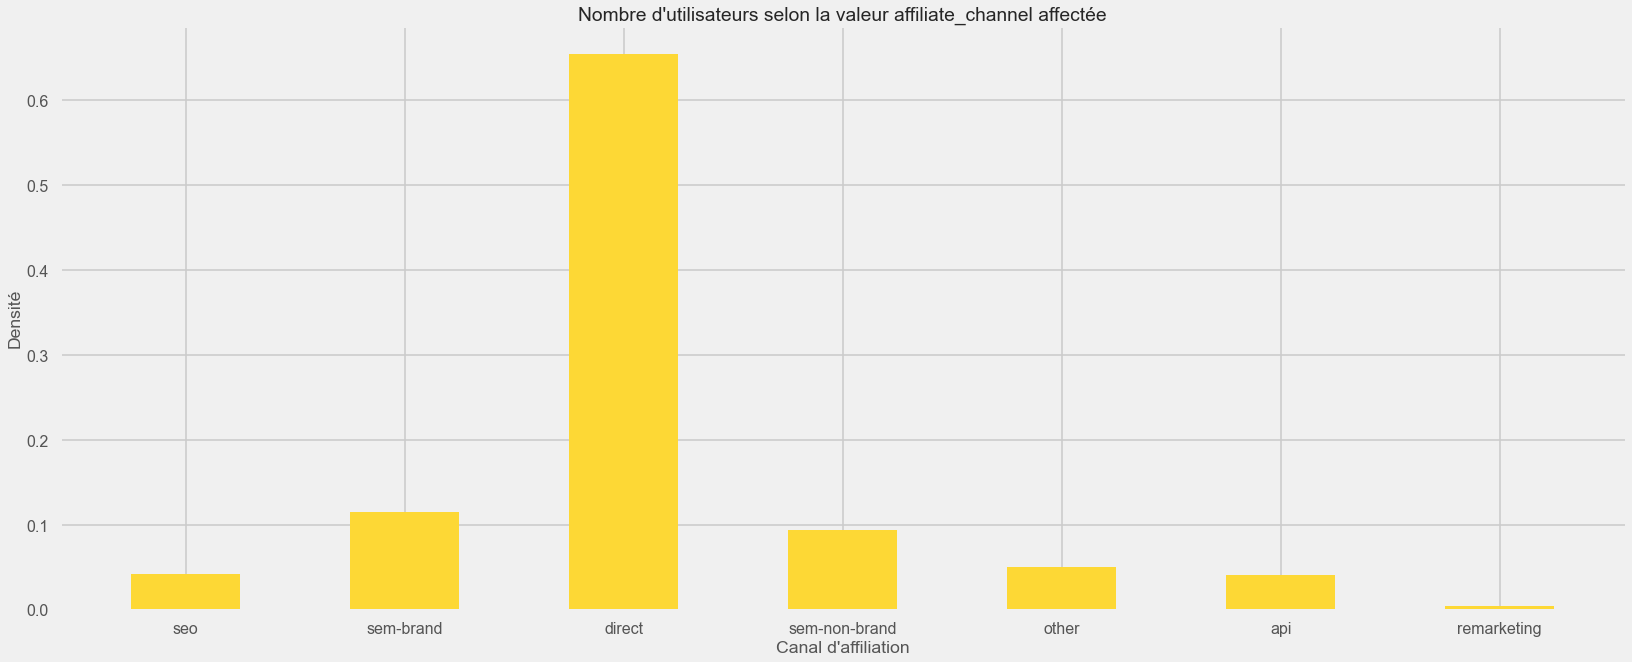

In [164]:
ax = users['affiliate_channel'].hist(bins=np.arange(users['affiliate_channel'].nunique())-0.5, rwidth=0.5, figsize=(25, 10), color='#fdd835', density=True)
ax.set_title("Nombre d'utilisateurs selon la valeur affiliate_channel affectée")
ax.set_ylabel("Densité")
_ = ax.set_xlabel("Canal d'affiliation")

La plupart du temps, les utlisateurs viennent directement sur le site d'Airbnb sans l'aide d'une quelconque campagne d'affiliation (valeur "direct") comme le montre l'histogramme :
* la valeur "direct" est représenté à plus de 60%,
* les autres valeurs peinent à atteindre les 12%.

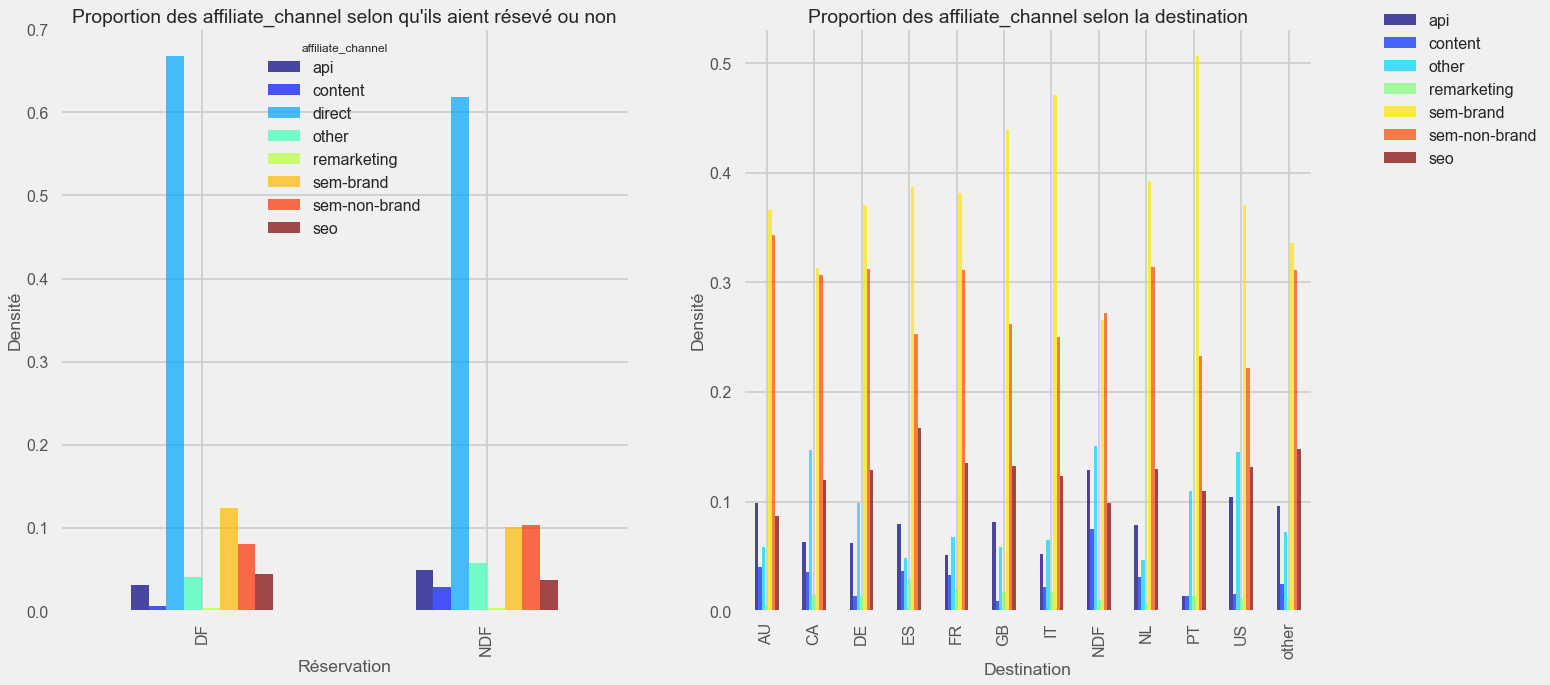

In [139]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
var = pd.crosstab(users['destination_found'], users['affiliate_channel'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='jet', alpha=0.7)
ax1.set_title("Proportion des affiliate_channel selon qu'ils aient résevé ou non")
ax1.set_xlabel('Réservation')
ax1.set_ylabel('Densité')

var = pd.crosstab(users[users['affiliate_channel'] != 'direct']['country_destination'], users[users['affiliate_channel'] != 'direct']['affiliate_channel'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='jet', alpha=0.7)
plt.legend(bbox_to_anchor=(1.1, 1.05))
ax2.set_ylabel('Densité')
ax2.set_xlabel("Destination")
_ = ax2.set_title("Proportion des affiliate_channel selon la destination")

On voit que :
* la valeur "direct" est légèrement plus importante parmi les DF que les NDF. Il est possible que les utilisateurs se rendant directement sur le site ont une idée de destination en tête ou l'envie de voyager ce qui augmente la tentation de réserver.
* la valeur "sem_brand" est un peu plus présente chez les DF à environ 12%
* la valeur "sem_non_brand", "content" et "api" sont plus représentées du côté des ND à 10%.

Du côté des destinations, la valeur "direct" prend trop d'importance sans pour autant permettre de discriminer les données et a donc été filtrée.

Au final, peu d'information pertinente ont pu être tirées de cette variable.

### Affiliate_provider

On va s'intéresser aux sites et plateformes affiliés à partir duquel l'utilisateur est venu. Cette variable contient beaucoup de valeurs ce qui nuit à la visualisation des données. On va donc regrouper les valuers les moins présentes ensemble en une valuer nommée "exit_group".

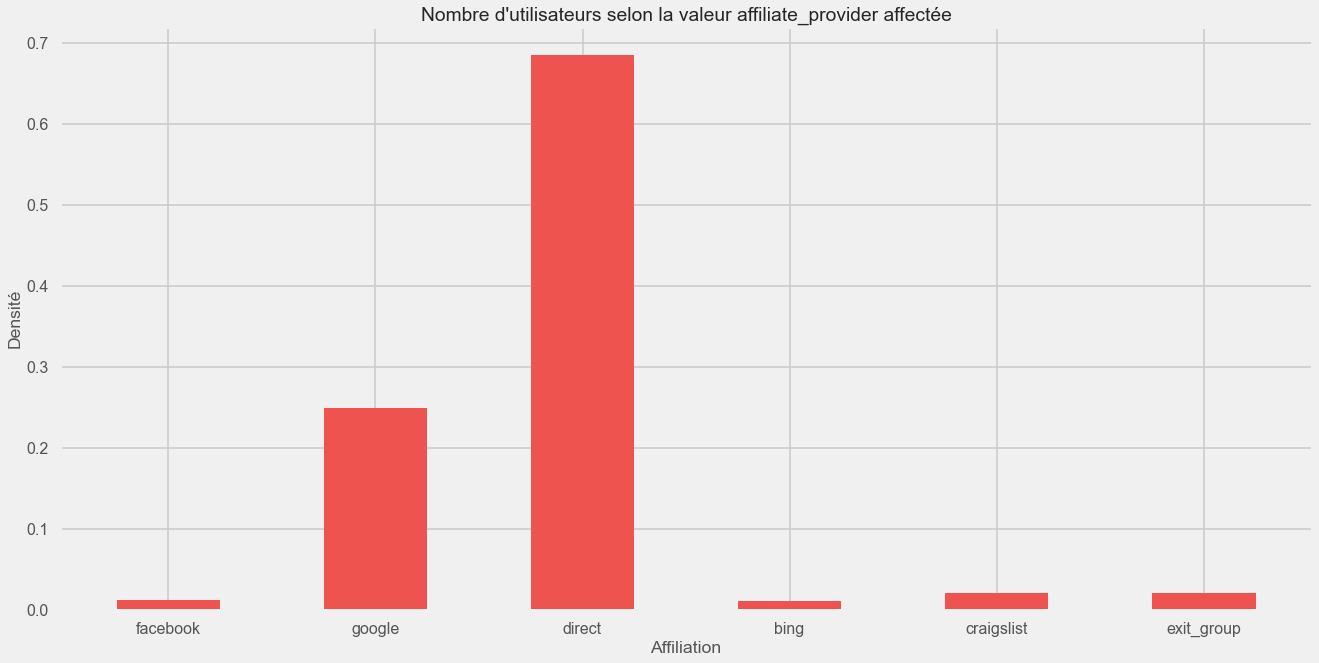

In [140]:
providers = users.groupby('affiliate_provider').count()[['id']].rename({'id': 'count'})
providers = providers[providers['id'] > 1000]
provider_names = set(providers.index)

users['affiliate_provider_processed'] = users.apply(lambda r: r['affiliate_provider'] if r['affiliate_provider'] in provider_names else 'exit_group', axis=1)

plt.figure(figsize=(20, 10))
ax = users['affiliate_provider_processed'].hist(bins=np.arange(users['affiliate_provider_processed'].nunique())-0.5, rwidth=0.5, color='#ef5350', density=True)
ax.set_title("Nombre d'utilisateurs selon la valeur affiliate_provider affectée")
ax.set_ylabel('Densité')
_ = ax.set_xlabel('Affiliation')

On observe que : 
* la valeur "direct" revient à 66% environ (comme précedemment),
* la plupart des utilisateurs provenant d'un site affilié viennent d'une annonce depuis "google" à environ 24%.

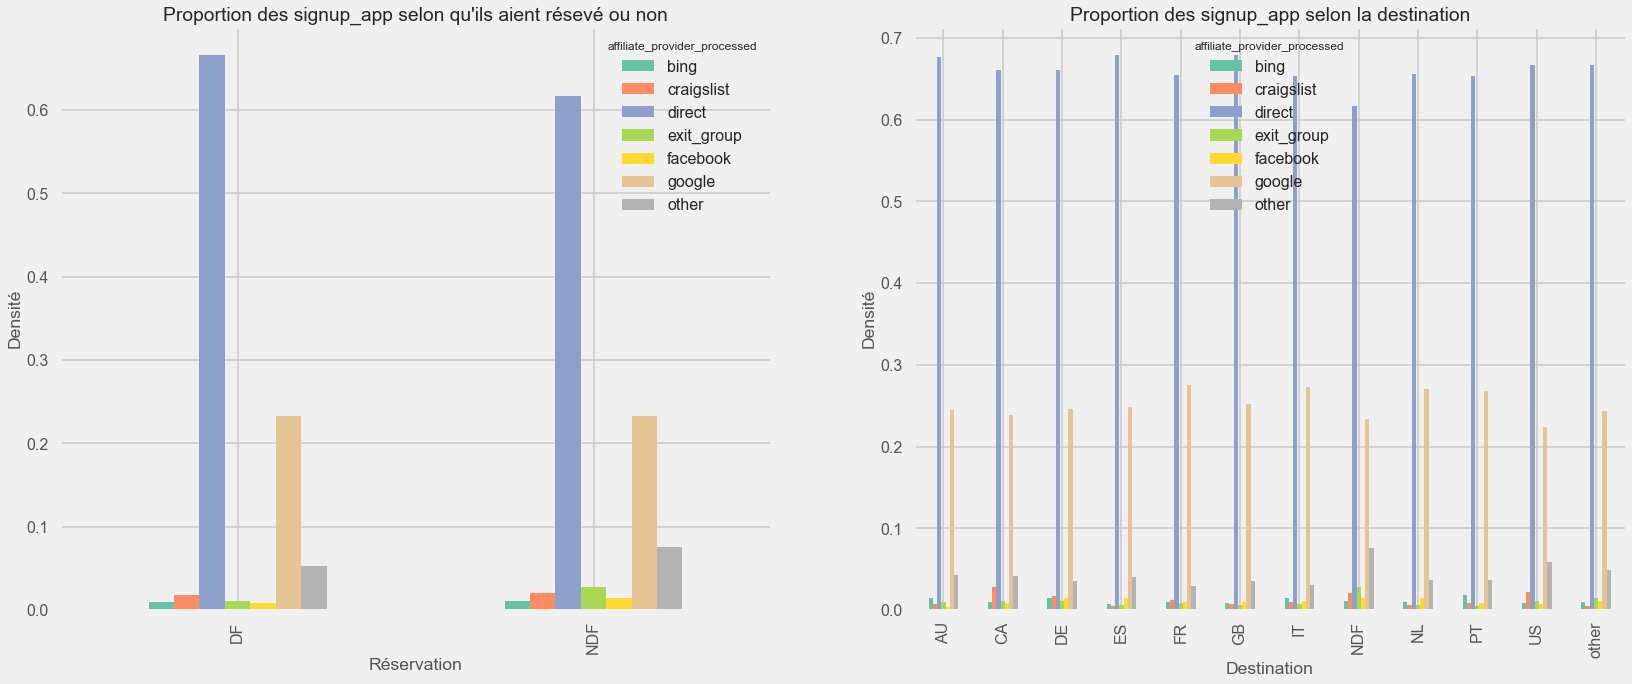

In [141]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
var = pd.crosstab(users['destination_found'], users['affiliate_provider_processed'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='Set2')
ax1.set_title("Proportion des signup_app selon qu'ils aient résevé ou non")
ax1.set_xlabel('Réservation')
ax1.set_ylabel('Densité')

var = pd.crosstab(users['country_destination'], users['affiliate_provider_processed'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='Set2')
ax2.set_ylabel('Densité')
ax2.set_xlabel("Destination")
_ = ax2.set_title("Proportion des signup_app selon la destination")

On remarque que les utilisateurs qui ne réservent pas (NDF) et qui viennet d'un site affilié ont une plus grande tendance à provenir de plateformes diverse et peu connues que les Df comme le montre le pourcentage plus élevé de "exit_group" et "other" parmi les NDF. 

Peu de conclusions peuvent être déduite de cette variable au sujet des différentes destinations.

### First affiliate tracked

On va s'intéresser à la première affiliation qui est entrée en intéraction avec l'utilisateur avant son inscription sur la plateforme d'Airbnb. Cette variable contient de valeurs NaN à remplacer par "-unknown-" avant analyse (voir le notebook introductif).

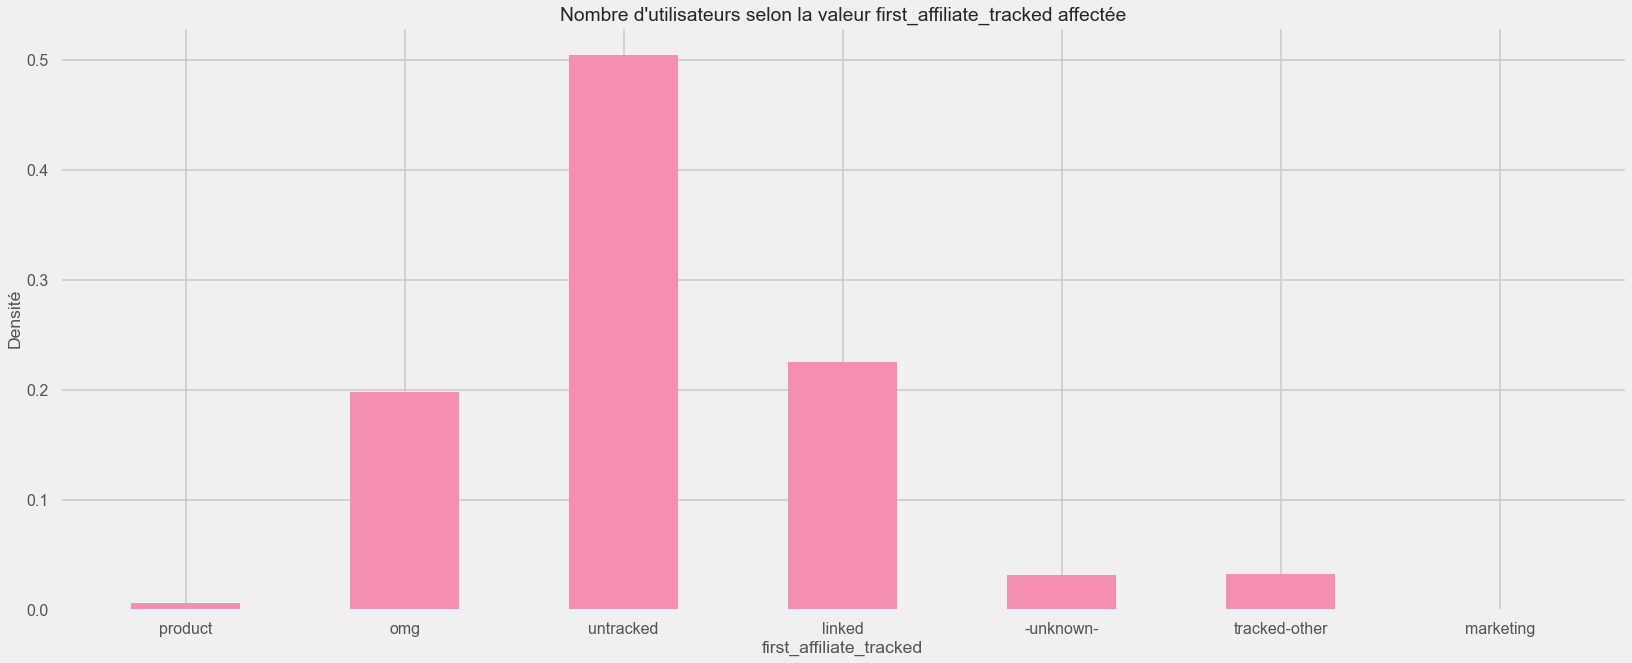

In [142]:
aff_tracked_users = users.fillna('-unknown-')
ax = aff_tracked_users['first_affiliate_tracked'].hist(bins=np.arange(8)-0.5, rwidth=0.5, figsize=(25, 10), color='#f48fb1', density=True)
ax.set_title("Nombre d'utilisateurs selon la valeur first_affiliate_tracked affectée")
ax.set_ylabel("Densité")
_ = ax.set_xlabel('first_affiliate_tracked')

* La valeur untracked est représentée à 50% environ.
* La valeur "linked" et "omg" sont les secondes valeurs la plus représentée à 22% et 20%.
* Les autres valeurs sont à peine représentées à plus de 5%.

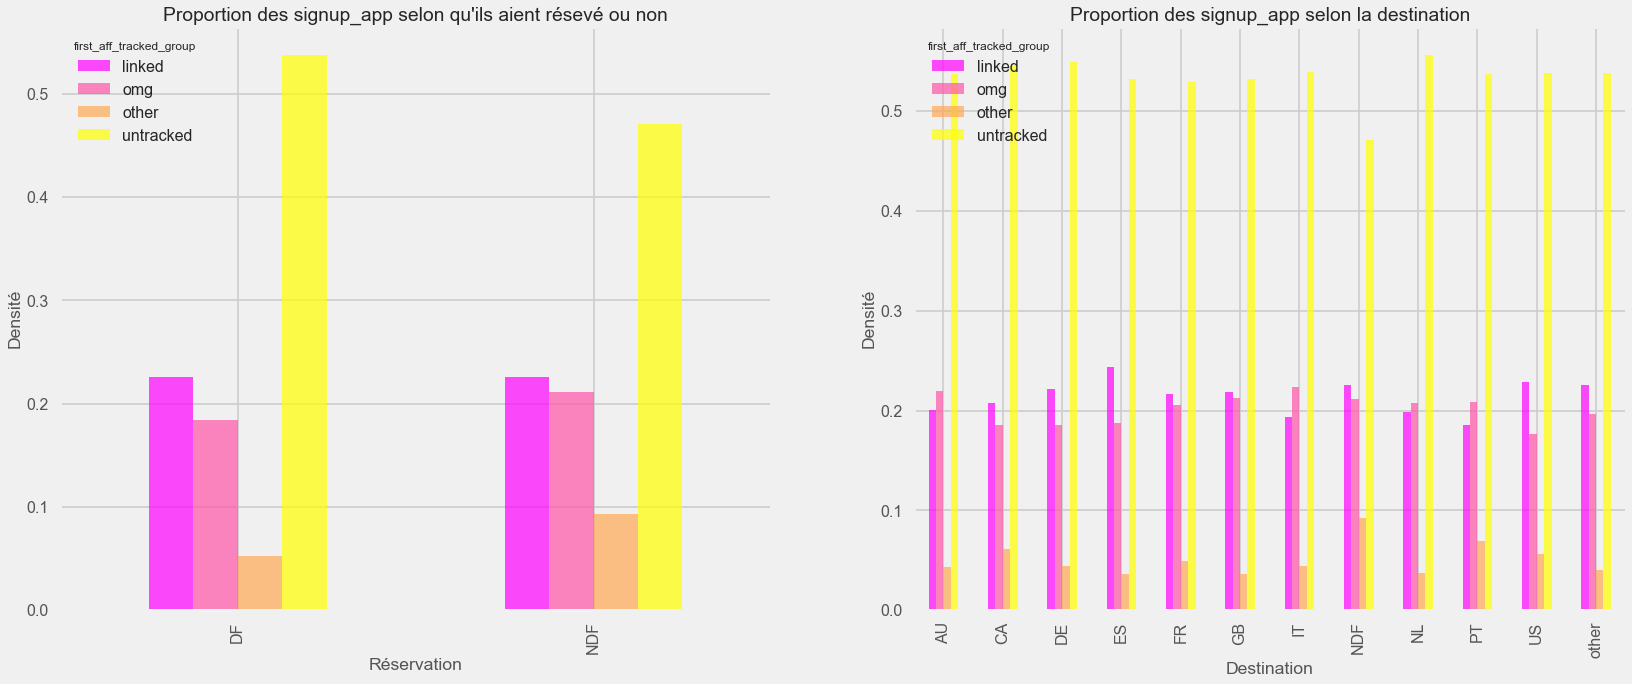

In [143]:
auth_affs = ['untracked', 'linked', 'omg']
aff_tracked_users['first_aff_tracked_group'] = aff_tracked_users.apply(lambda r: r['first_affiliate_tracked'] if r['first_affiliate_tracked'] in auth_affs else 'other', axis=1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
var = pd.crosstab(aff_tracked_users['destination_found'], aff_tracked_users['first_aff_tracked_group'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='spring', alpha=0.7)
ax1.set_title("Proportion des signup_app selon qu'ils aient résevé ou non")
ax1.set_xlabel("Réservation")
ax1.set_ylabel("Densité")

var = pd.crosstab(aff_tracked_users['country_destination'], aff_tracked_users['first_aff_tracked_group'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='spring', alpha=0.7)
ax2.set_ylabel("Densité")
ax2.set_xlabel("Destination")
_ = ax2.set_title("Proportion des signup_app selon la destination")

On peut voir que la valeur "product" apparait plus souvent chez les individus qui réservent au Portugal (PT) par rapport aux autres destinations. La valeur "-unknown-" est plus présente du côté des NDF.

Très peu d'information peuvent être déduite de cette variable. Les proportions sont quasi-identiques d'une classe à l'autre.

### Signup_app

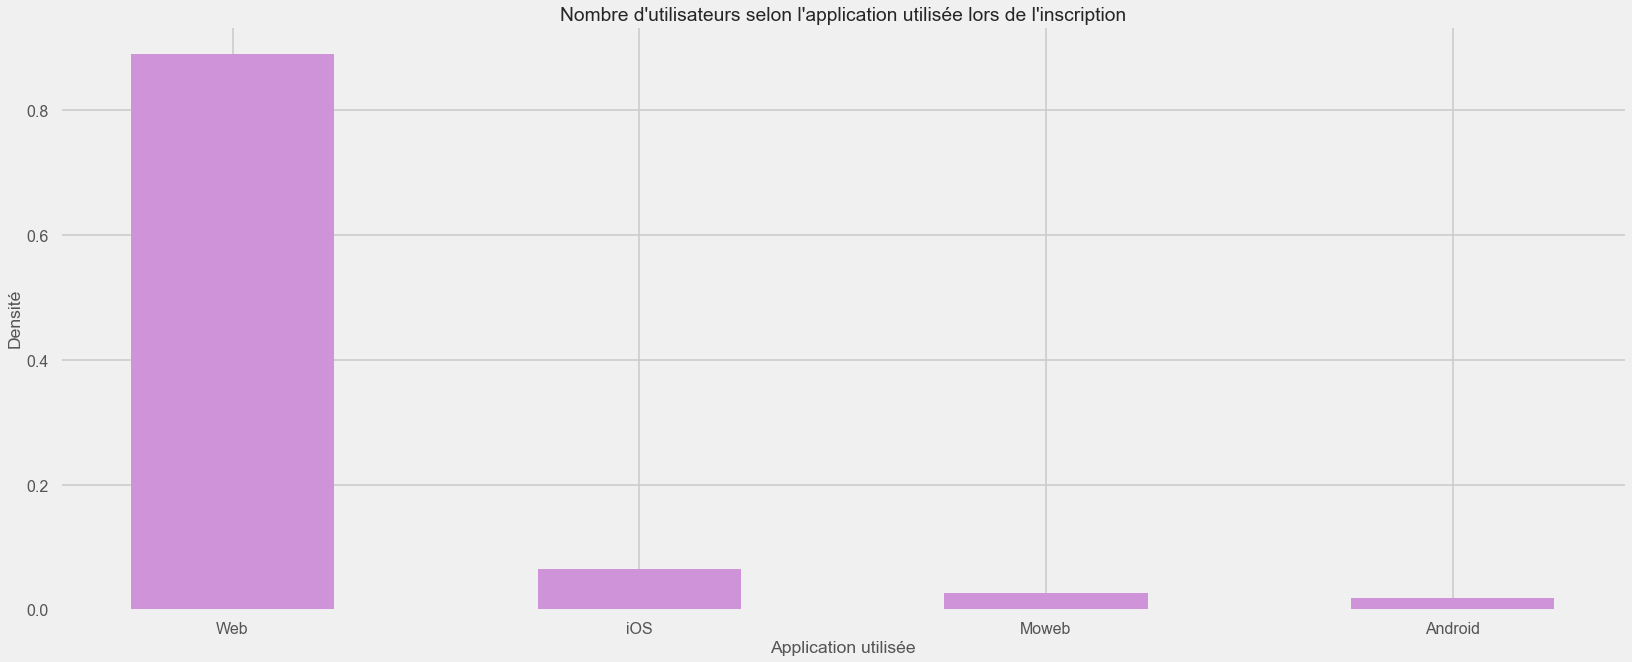

In [144]:
ax = users['signup_app'].hist(bins=np.arange(5)-0.5, rwidth=0.5, figsize=(25, 10), color='#ce93d8', density=True)
ax.set_title("Nombre d'utilisateurs selon l'application utilisée lors de l'inscription")
ax.set_ylabel('Densité')
_ = ax.set_xlabel('Application utilisée')

On voit que : 
* peu d'individus se sont inscrits depuis un appareil iOS, mobile ou Android (< 1%).
* une forte majorité passe par l'application web. Cela ne semble pas étrange étant donné qu'il était peut être plus inhabituel d'effectuer des payements et recherche via un smartphone avant 2014. 

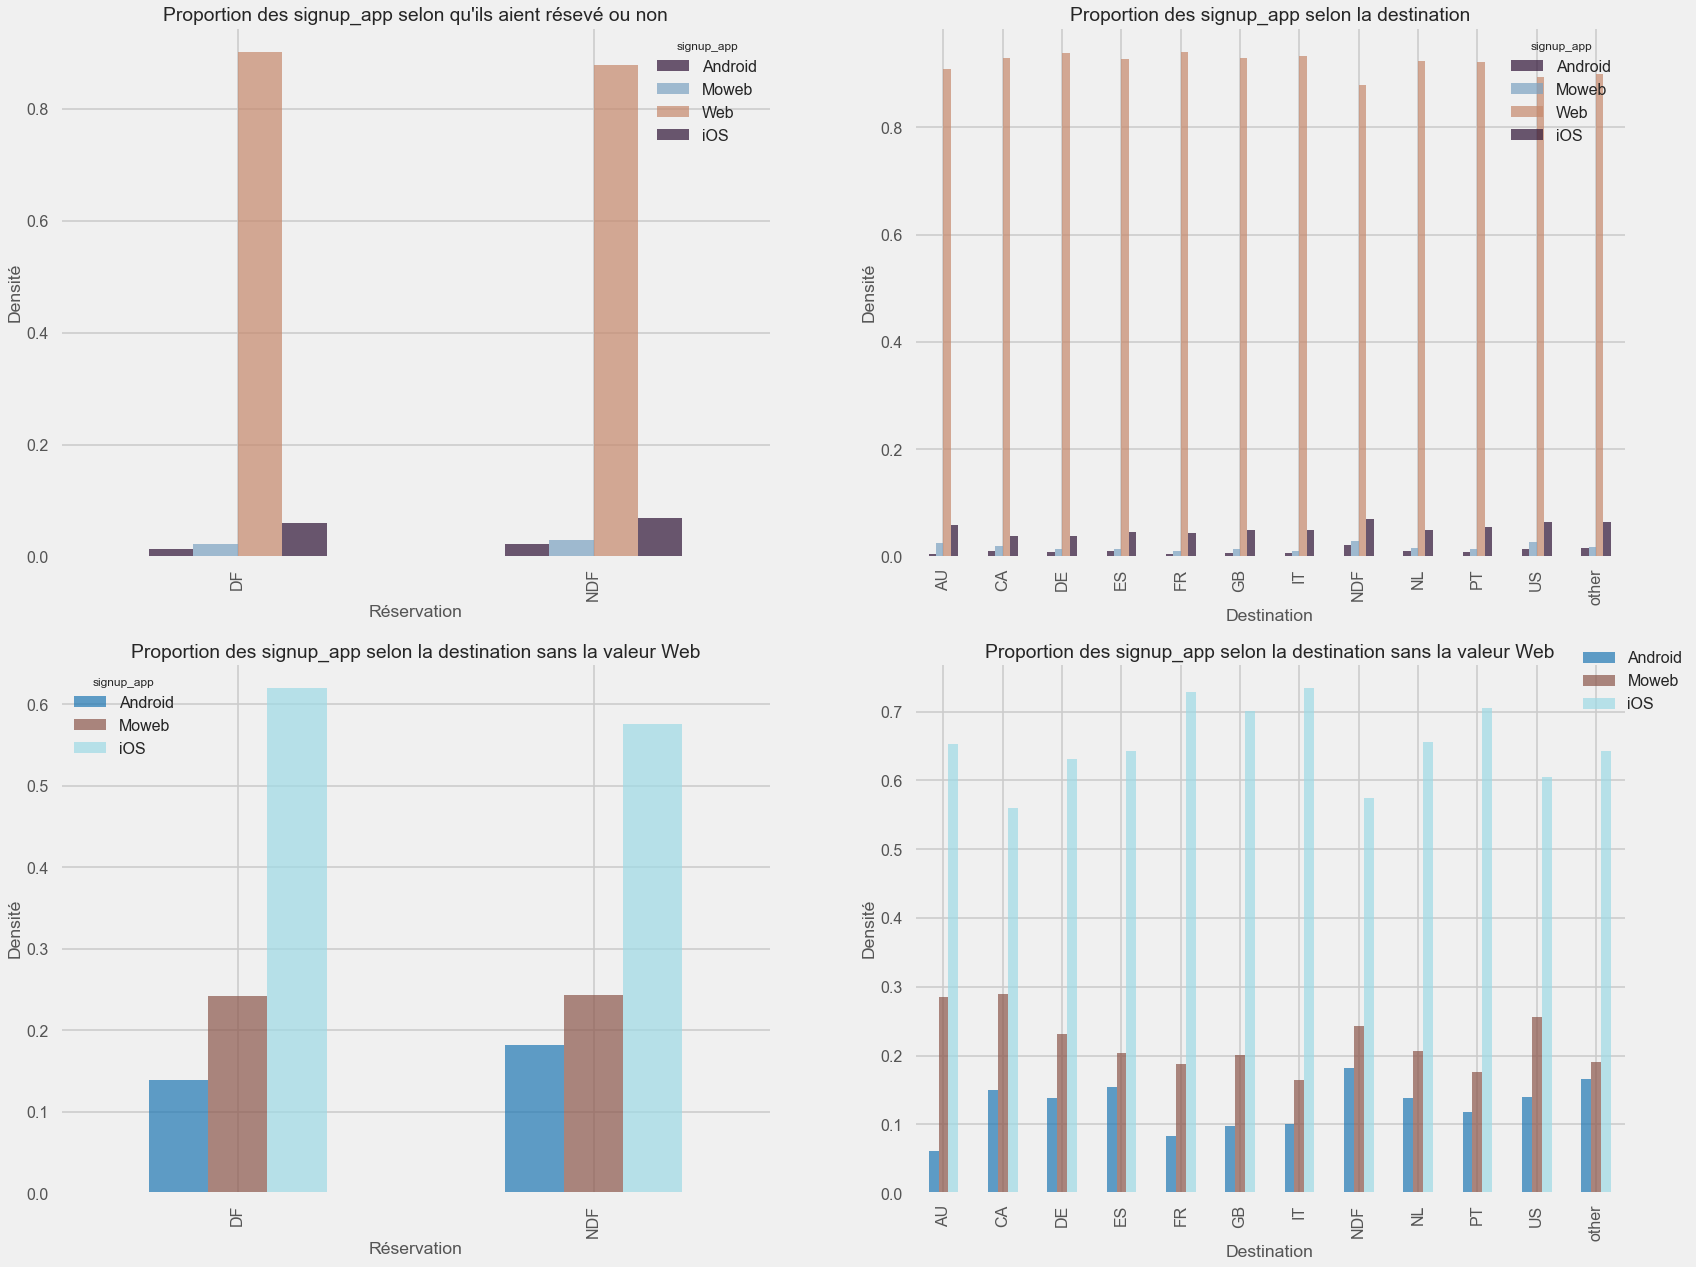

In [145]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(25, 20))
var = pd.crosstab(users['destination_found'], users['signup_app'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='twilight_shifted', alpha=.7)
ax1.set_title("Proportion des signup_app selon qu'ils aient résevé ou non")
ax1.set_xlabel("Réservation")
ax1.set_ylabel("Densité")

var = pd.crosstab(users['country_destination'], users['signup_app'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='twilight_shifted', alpha=.7)
ax2.set_title("Proportion des signup_app selon la destination")
ax2.set_ylabel("Densité")
ax2.set_xlabel('Destination')


noweb_users = users[users['signup_app'] != 'Web']
var = pd.crosstab(noweb_users['destination_found'], noweb_users['signup_app'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax3, colormap='tab20', alpha=.7)
ax3.set_title("Proportion des signup_app selon la destination sans la valeur Web")
ax3.set_ylabel("Densité")
ax3.set_xlabel('Réservation')


var = pd.crosstab(noweb_users['country_destination'], noweb_users['signup_app'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax4, colormap='tab20', alpha=.7)
plt.legend(bbox_to_anchor=(1.1, 1.05))
ax4.set_ylabel("Densité")
ax4.set_xlabel('Destination')
_ = ax4.set_title("Proportion des signup_app selon la destination sans la valeur Web")

* On voit une plus grande utilisation de l'application Android du côté des NDF que du côté des DF (19% contre 12%).
* À l'inverse, on observe une très légère tendance pour l'utilisation de l'application iOS du côté des DF.

Dans chaque destination, l'application Web est la plus utilisée suivis de l'application iOS. 

### First_device_type

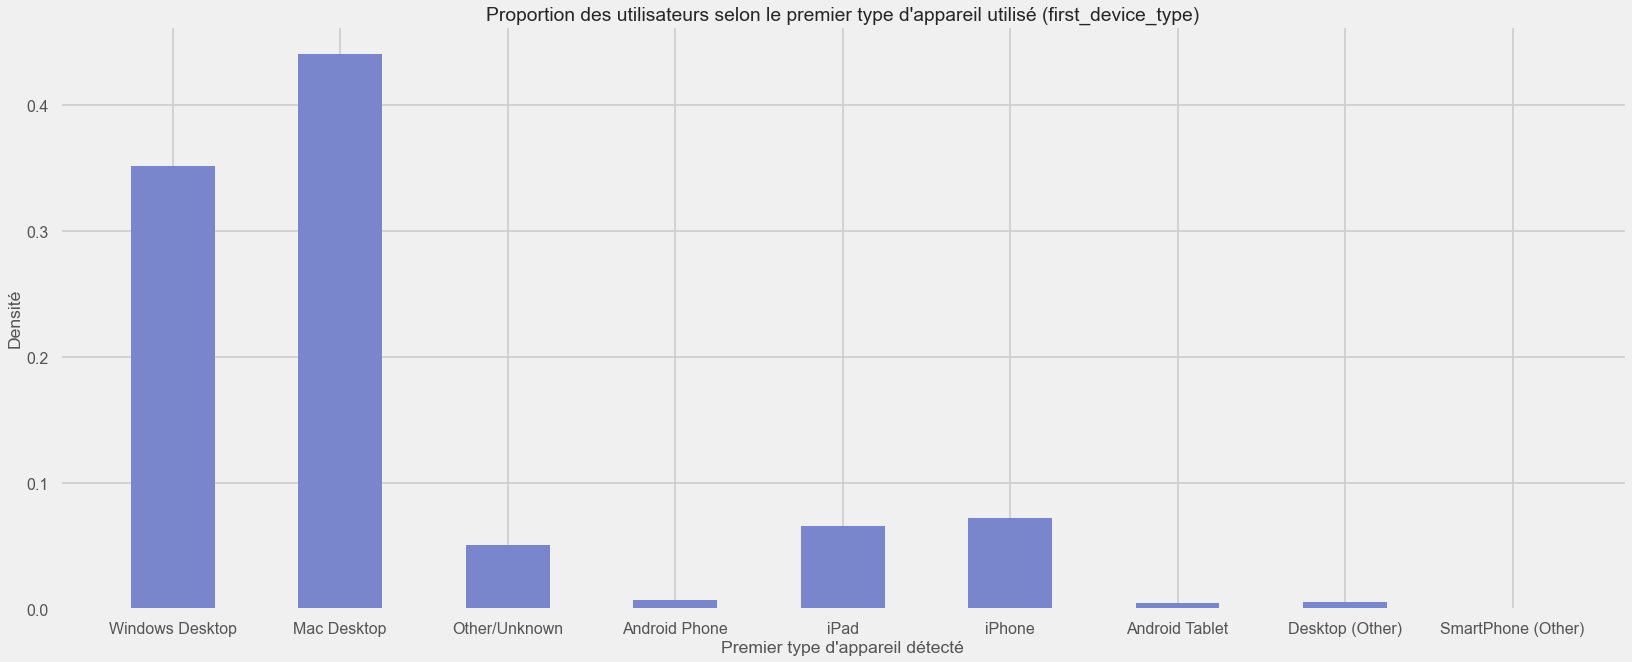

In [146]:
ax = users['first_device_type'].hist(figsize=(25, 10), bins=np.arange(10)-0.5, rwidth=0.5, density=True, color='#7986cb')
ax.set_title("Proportion des utilisateurs selon le premier type d'appareil utilisé (first_device_type)")
ax.set_xlabel("Premier type d'appareil détecté")
_ = ax.set_ylabel('Densité')

* 43% des utilisateurs se sont connectés depuis un "Mac desktop" en prelier lieu. 
* 36% utilise "Windows Desktop". 
* L'utilisation de tablets et smartphone est très faible par rapport à l'utilisation d'un ordinateur. Cela rejoint l'hypothèse qu'il serait plus simple d'utiliser un ordinateur qu'un téléphone pour réserver ou effectuer des recherches. 

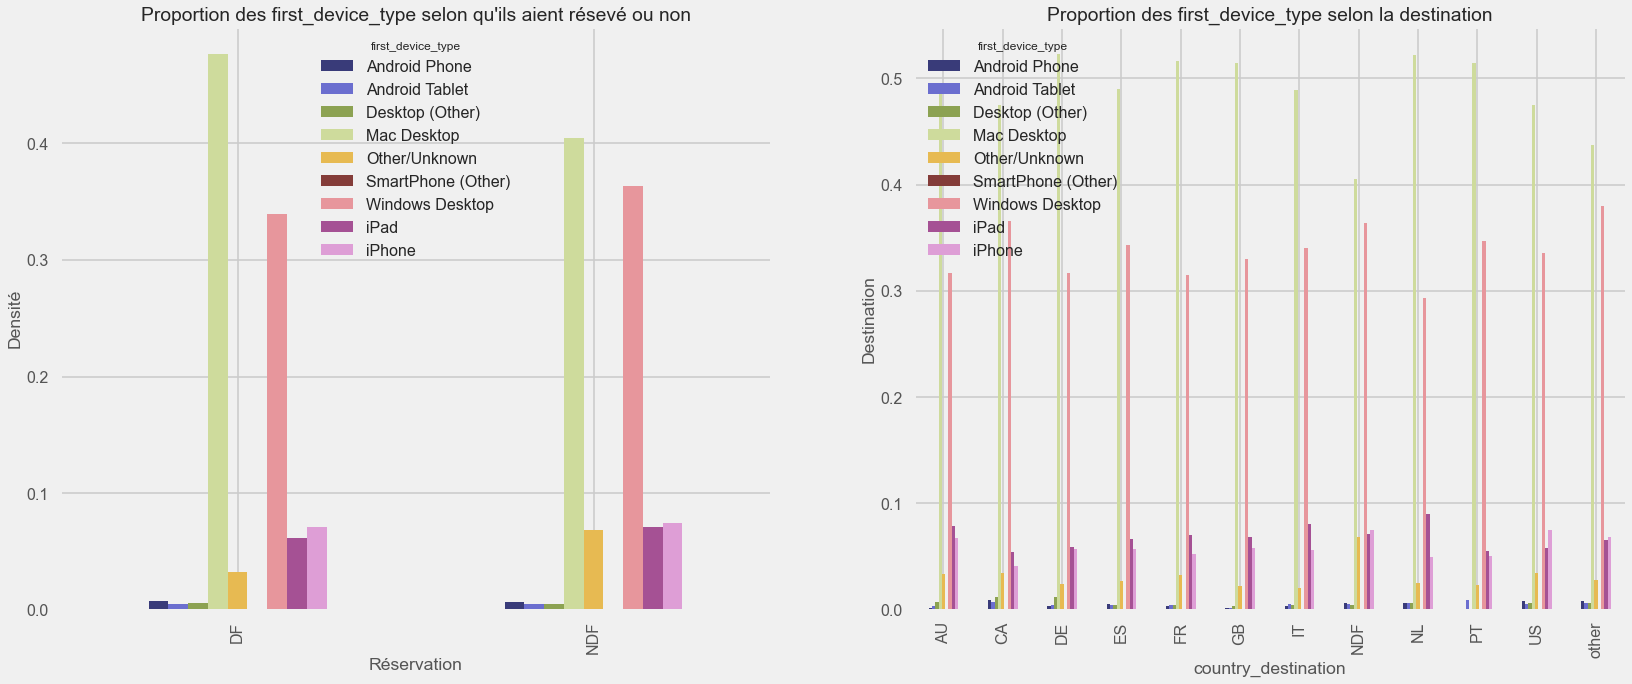

In [147]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
var = pd.crosstab(users['destination_found'], users['first_device_type'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='tab20b')
ax1.set_title("Proportion des first_device_type selon qu'ils aient résevé ou non")
ax1.set_xlabel('Réservation')
ax1.set_ylabel('Densité')

var = pd.crosstab(users['country_destination'], users['first_device_type'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2, colormap='tab20b')
ax2.set_ylabel('Densité')
ax2.set_ylabel('Destination')
_ = ax2.set_title("Proportion des first_device_type selon la destination")

* La proportion de "Mac Desktop" est légèrement plus importante chez les DF que les NDF (48% contre 40%).
* Chaque destination suit plus ou moins les mêmes proportions pour chaque valeur.

### First_browser

Cette variable possède beaucoup de valeurs dont la plupart sont très peu répendues. On peut donc, pour simplifier l'affichage graphique, regrouper ces éléments ensemble. avant d'afficher un graphique. Prenons les navigateurs ayant été détectés au moins 1000 fois.

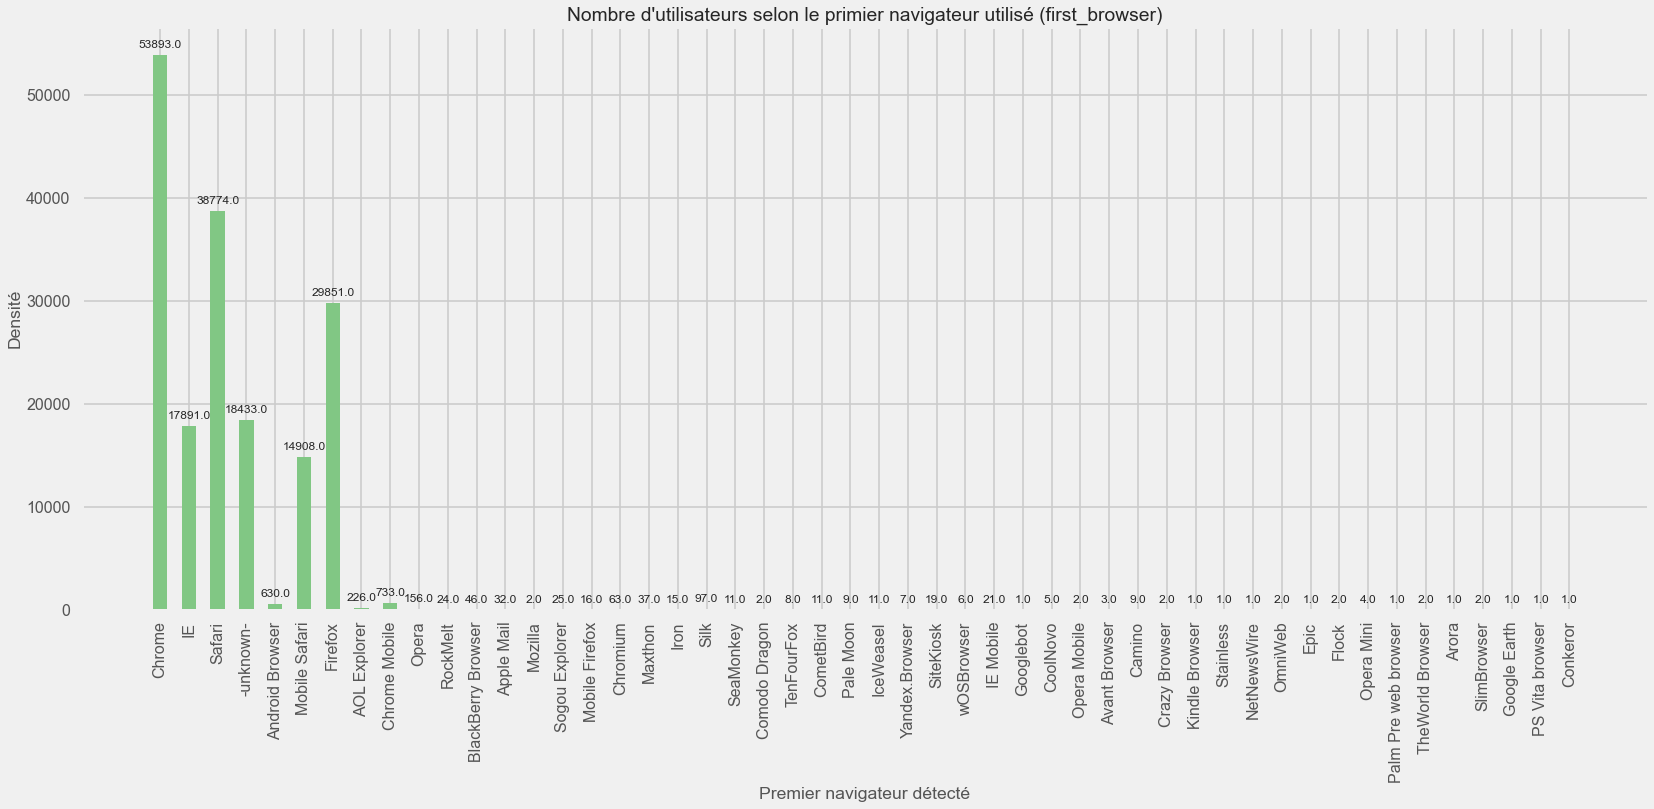

In [148]:
ax = users['first_browser'].hist(figsize=(25, 10), bins=np.arange(users['first_browser'].nunique()+1)-0.5, rwidth=0.5, color='#81c784')
ax.set_title("Nombre d'utilisateurs selon le primier navigateur utilisé (first_browser)")
ax.set_ylabel('Densité')
ax.set_xlabel('Premier navigateur détecté')
plt.xticks(rotation='vertical')
autolabel(ax.patches, ax)

* Le navigateur le plus utilisé est Chrome avec plus de 50000 utilisateurs.
* Seuls 6 navigateurs ont plus de 10000 utilisateurs.

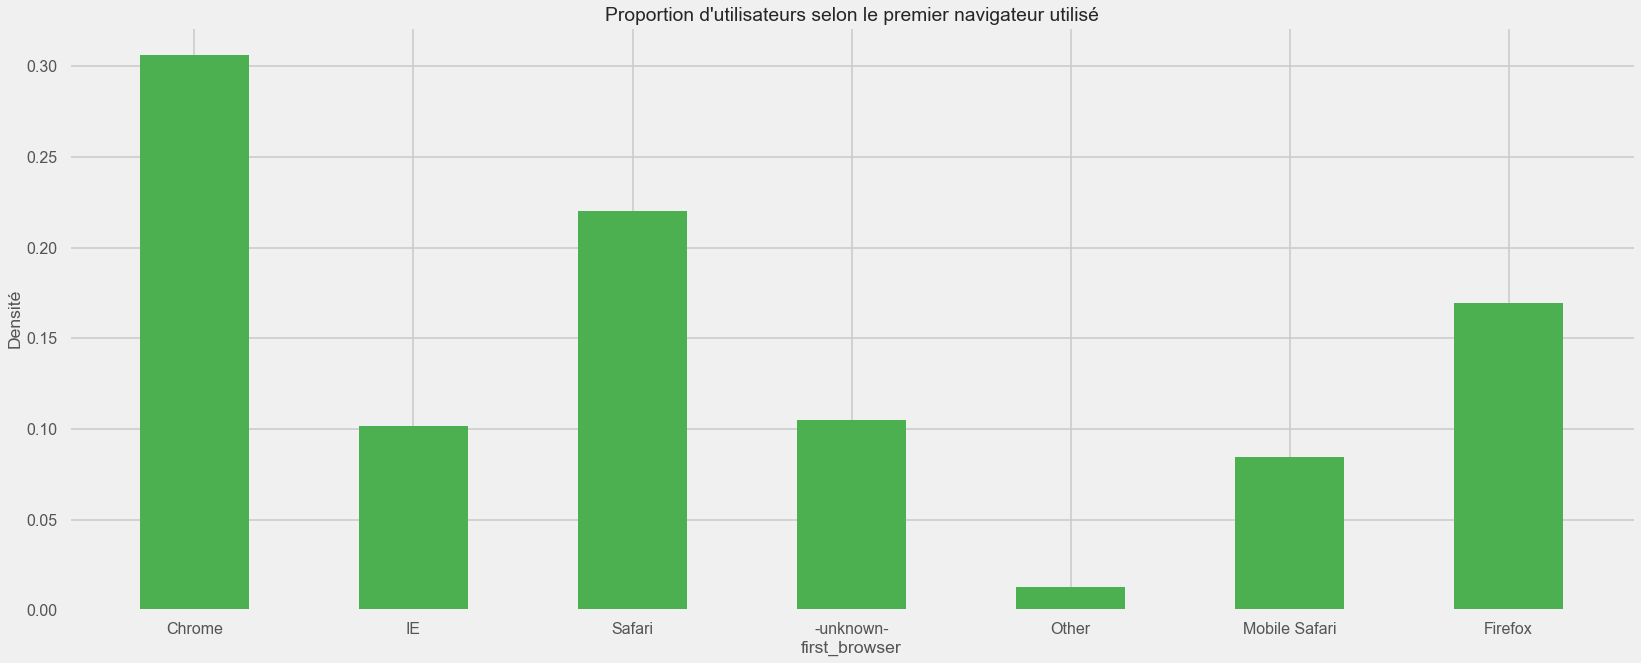

In [149]:
users_browsers = users.groupby('first_browser').count()[['id']].sort_values(by='id')
browsers = set(users_browsers[users_browsers['id'] > 1000].index)
users['first_browsers_processed'] = users.apply(lambda r: r['first_browser'] if r['first_browser'] in browsers else 'Other', axis=1)

ax = users['first_browsers_processed'].hist(bins=np.arange(users['first_browsers_processed'].nunique()+1)-0.5, 
                                            rwidth=0.5, density=True, figsize=(25,10), color='#4caf50')
ax.set_title("Proportion d'utilisateurs selon le premier navigateur utilisé")
ax.set_ylabel('Densité')
_ = ax.set_xlabel('first_browser')

* Chrome est utilisé à plus de 30% suivi de Safari à 24%.
* Les valeurs qui ont été regroupées ne représente que 2% des utilisateurs.

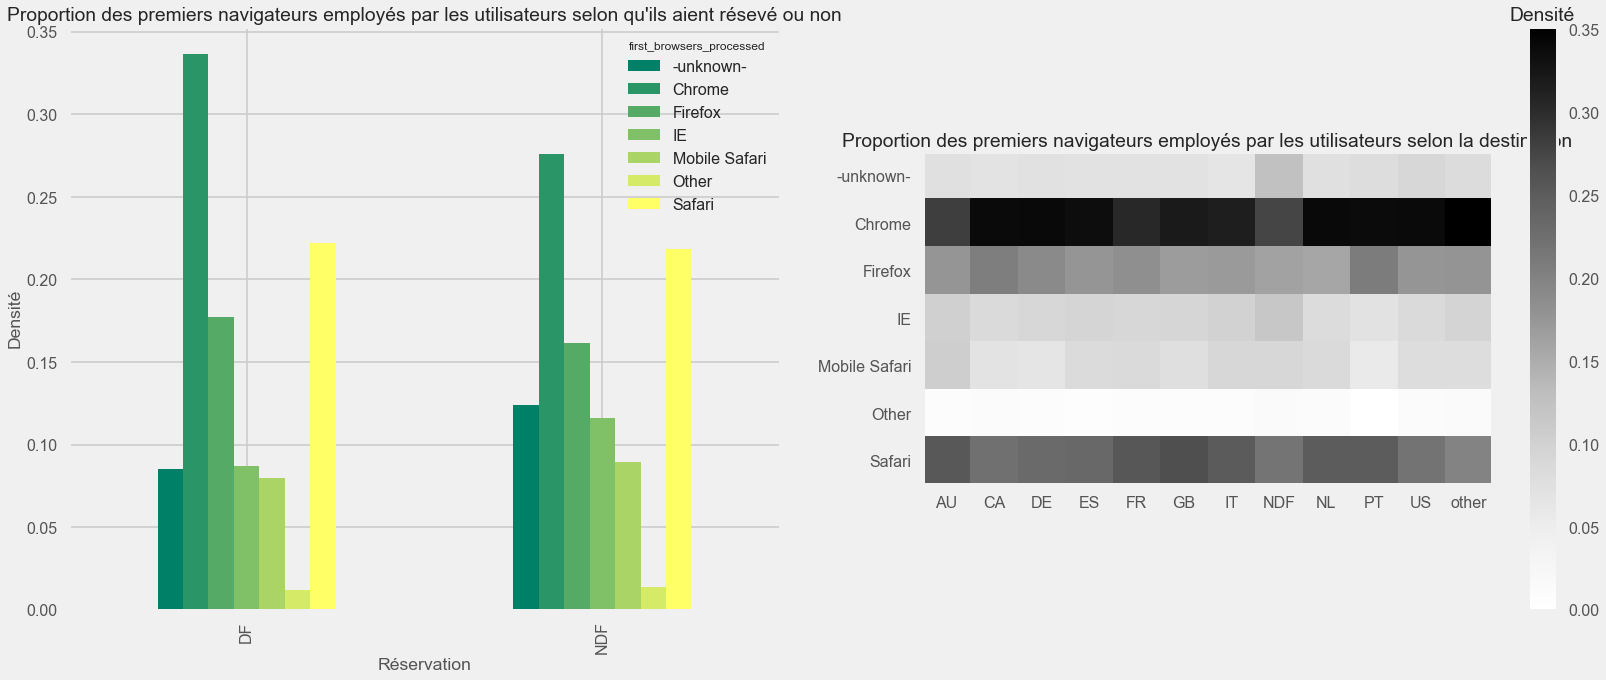

In [166]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
var = pd.crosstab(users['destination_found'], users['first_browsers_processed'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1, colormap='summer')
ax1.set_title("Proportion des premiers navigateurs employés par les utilisateurs selon qu'ils aient résevé ou non")
ax1.set_ylabel('Densité')
ax1.set_xlabel('Réservation')

browsers = pd.crosstab(users['first_browsers_processed'], users['country_destination'])
browsers = browsers.div(browsers.sum())
# fig, ax = plt.subplots(1, 1, figsize=(25, 10))
ax2.grid(False)
im = ax2.imshow(browsers)
ax2.set_title("Proportion des premiers navigateurs employés par les utilisateurs selon la destination")
ax2.set_xticks(range(browsers.shape[1]))
ax2.set_yticks(range(browsers.shape[0]))
ax2.set_xticklabels(browsers.columns)
ax2.set_yticklabels(browsers.index.values)
_ = fig.colorbar(im).ax.set_title("Densité")

* On distingue une plus grande proportion de "-unknown-" et d'Internet Explorer (IE) chez les NDF. 
* Il y a une plus grande poportion de Chrome chez les DF.
* Ceux réservant en Australie ont un plus grande tendance à utiliser Safari que le reste des utilisateurs.
* Ceux réservant au Portugal, 

## Analyse des données liées au temps

On va s'intéresser aux informations liées à la date de création du compte de l'utilisateur (date_account_created) et de sa première activité (timestamp_first_active). Cette dernière variable peut donc avoir une date antérieure à la création du compte.

In [151]:
# On reformatte les variable de temps
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')
users['date_account_created'] = pd.to_datetime(users['date_account_created'], format='%Y-%m-%d')
users["date_first_booking"] = pd.to_datetime(users['date_first_booking'], format='%Y-%m-%d')
users['date_first_active'] = pd.to_datetime(users['timestamp_first_active'].dt.date, format='%Y-%m-%d')
users['hour_first_active'] = users['timestamp_first_active'].dt.hour
users['month_first_active'] = users['date_first_active'].dt.month
users['year_first_active'] = users['date_first_active'].dt.year

In [152]:
booked_users = users[users['destination_found'] == 'DF']
delays = (booked_users['date_first_booking'] - booked_users['date_first_active'])
delays.describe()

count                      88000
mean     44 days 15:48:59.563636
std      88 days 10:49:25.739131
min              0 days 00:00:00
25%              1 days 00:00:00
50%              3 days 00:00:00
75%             29 days 00:00:00
max           1369 days 00:00:00
dtype: object

En moyenne, les gens réservent au bout de 44 jours. Cependant, l'écart-type montre que les délais sont assez hétérogènes ce qui peut expliquer cette valeur moyenne relativement élevée. On voit que la médiane est de 3 jours. Néanmoins, certains ont réservé après $\frac{1369}{365}=3.75$ ans. 

#### Le nombre d'inscrit en fonction du mois

NB : Que le mois soit extrait du "date_first_active" ou du "date_account_created", les résultats sont les mêmes. On choisit de poursuivre avec la variable "date_first_active".

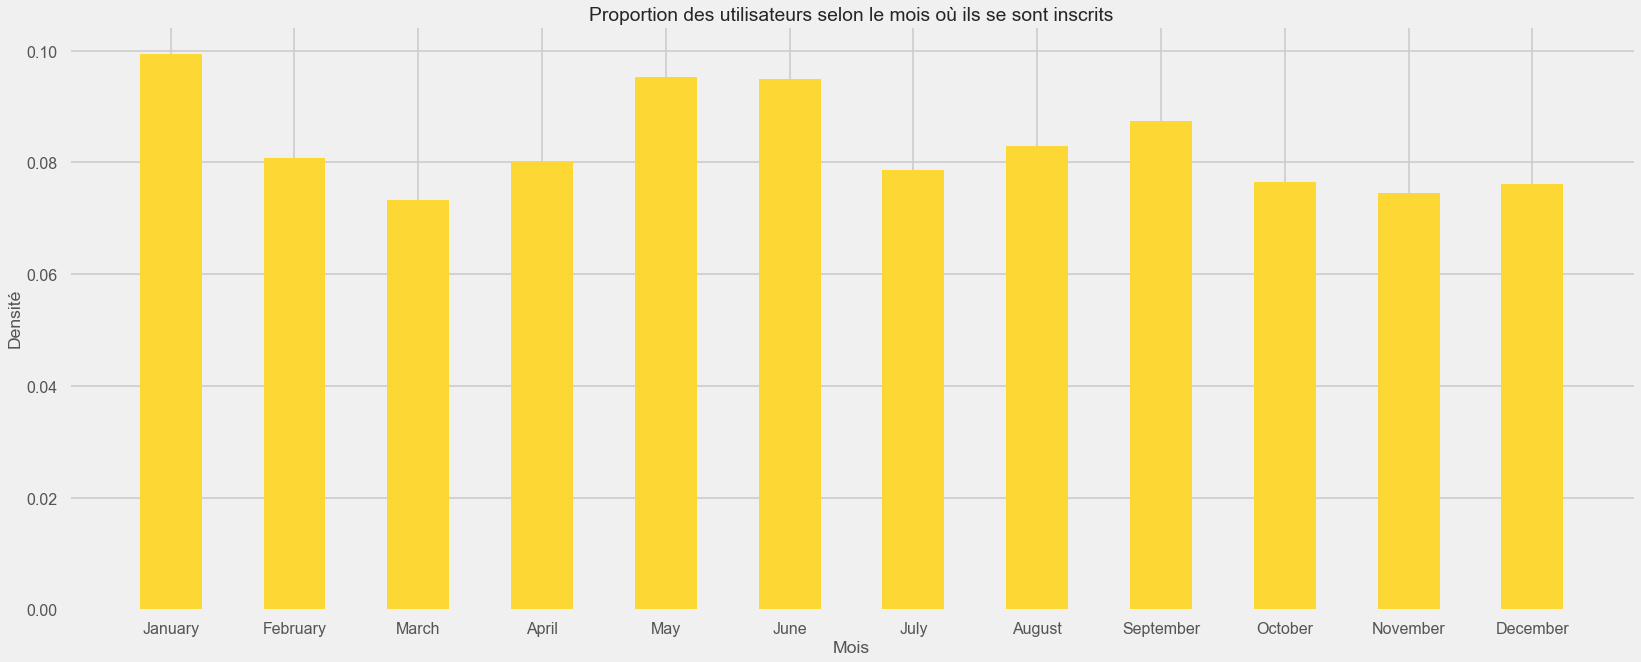

In [153]:
ax = users['month_first_active'].hist(bins=np.arange(13)+0.5, rwidth=0.5, density=True, figsize=(25, 10), color='#fdd835')
ax.set_xticks(range(1, 13))
ax.set_title("Proportion des utilisateurs selon le mois où ils se sont inscrits")
ax.set_ylabel('Densité')
ax.set_xticklabels(calendar.month_name[1:])
_ = ax.set_xlabel('Mois')

On voit une augmentation du nombre d'inscrit en janvier, mai et juin (probablement pour préparer les vacances d'été). 

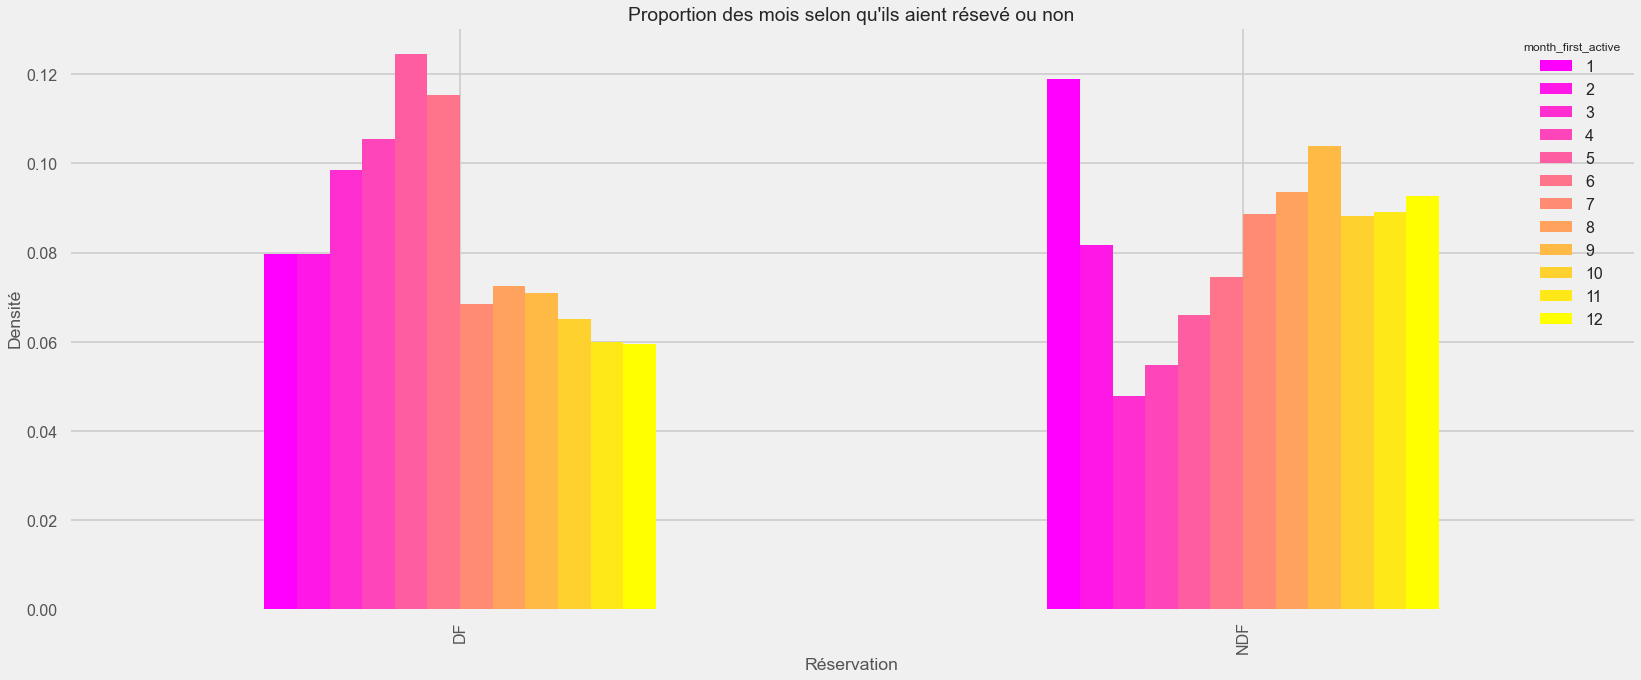

In [154]:
var = pd.crosstab(users['destination_found'], users['month_first_active'])
ax = var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, figsize=(25, 10), colormap='spring')
ax.set_ylabel('Densité')
ax.set_xlabel("Réservation")
_ = ax.set_title("Proportion des mois selon qu'ils aient résevé ou non")

On voit que :
* les utilisateurs ayant effectué une réservation s'inscrit le plus souvent au mois de mars à juin,
* les NDF s'inscrit particulièrement en janvier. Ils sont également plus fréquent vers la  seconde moitié de l'année.

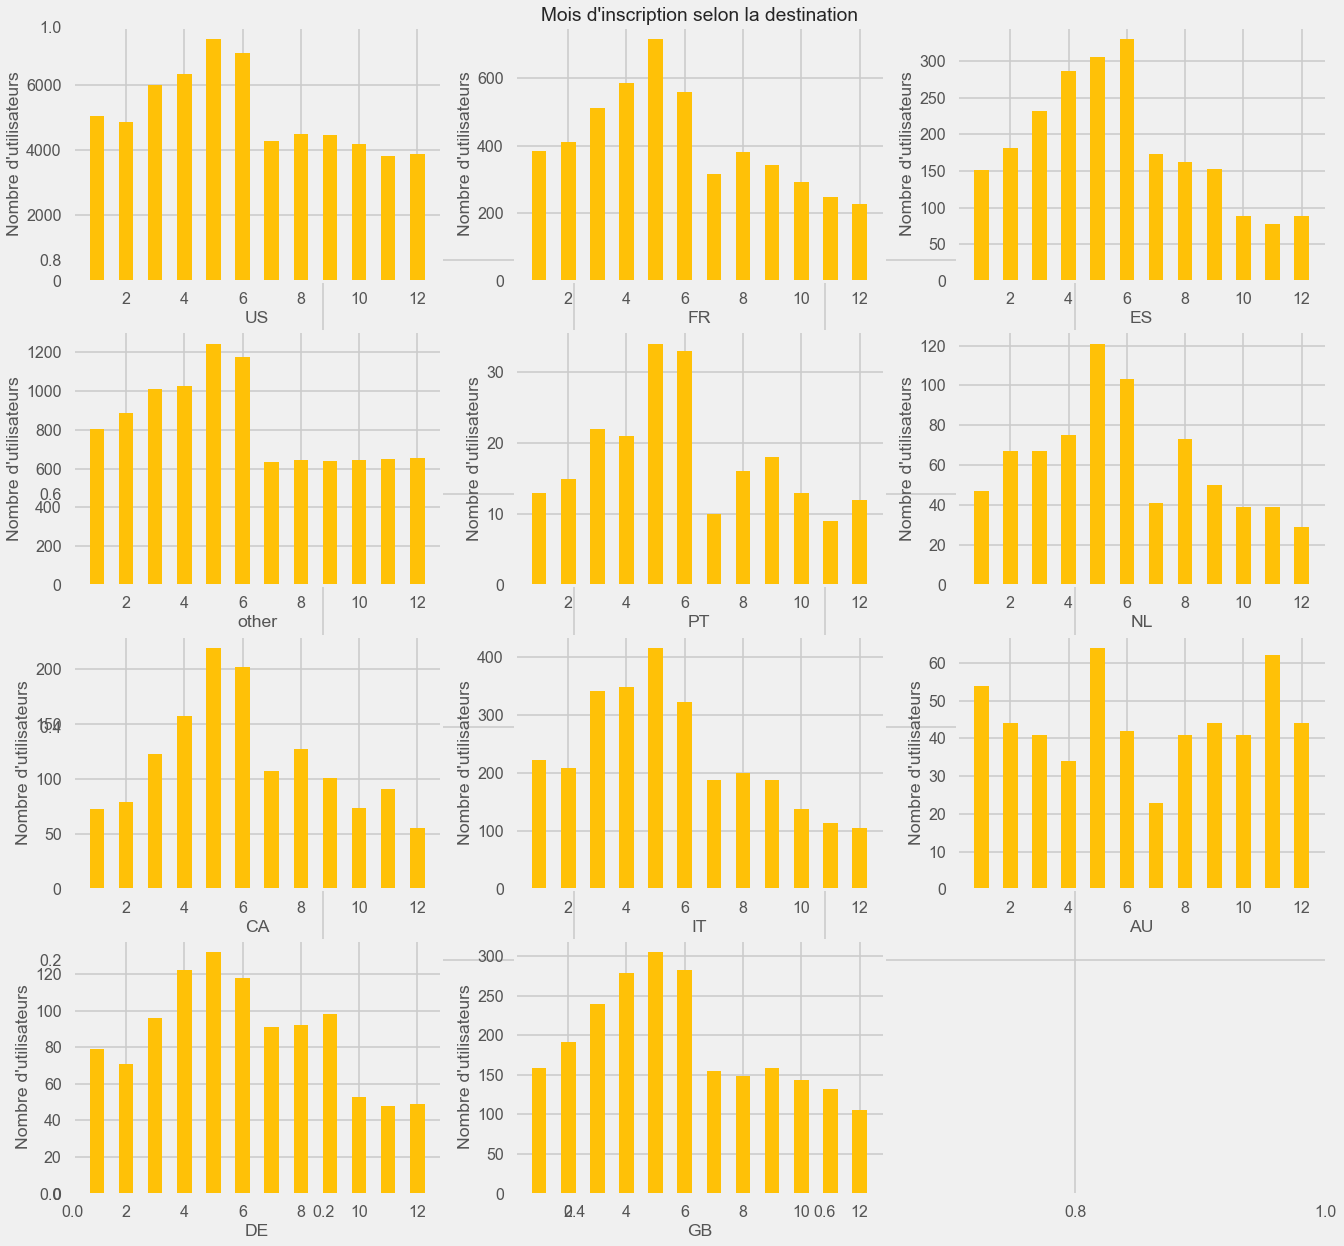

In [155]:
countries = users['country_destination'].unique().tolist()
countries.remove('NDF')

f = plt.figure(figsize=(20, 20))
plt.title("Mois d'inscription selon la destination")
for i, country in enumerate(countries):
    f.add_subplot(4, 3, i+1)
    plt.xlabel(country)
    plt.ylabel("Nombre d'utilisateurs")
    plt.hist(users[users['country_destination'] == country]['month_first_active'], bins=np.arange(13)+0.5, rwidth=0.5, color='#ffc107')

On remarque que tous les pays de l'hémisphère nord connaissent un pic vers mai/juin puis le nombre d'inscrit chute. Seul l'Australie (l'unique pays de l'hémisphère sud dans notre étude) a cette tendance inversée. On ressort l'idée que les utilisateurs préfèrent partir lorsque **le temps est plus chaud**.

#### Le nombre d'inscrit selon le jour

On peut s'attendre à ce que les utilisateurs réserve pour le week-end par exemple.

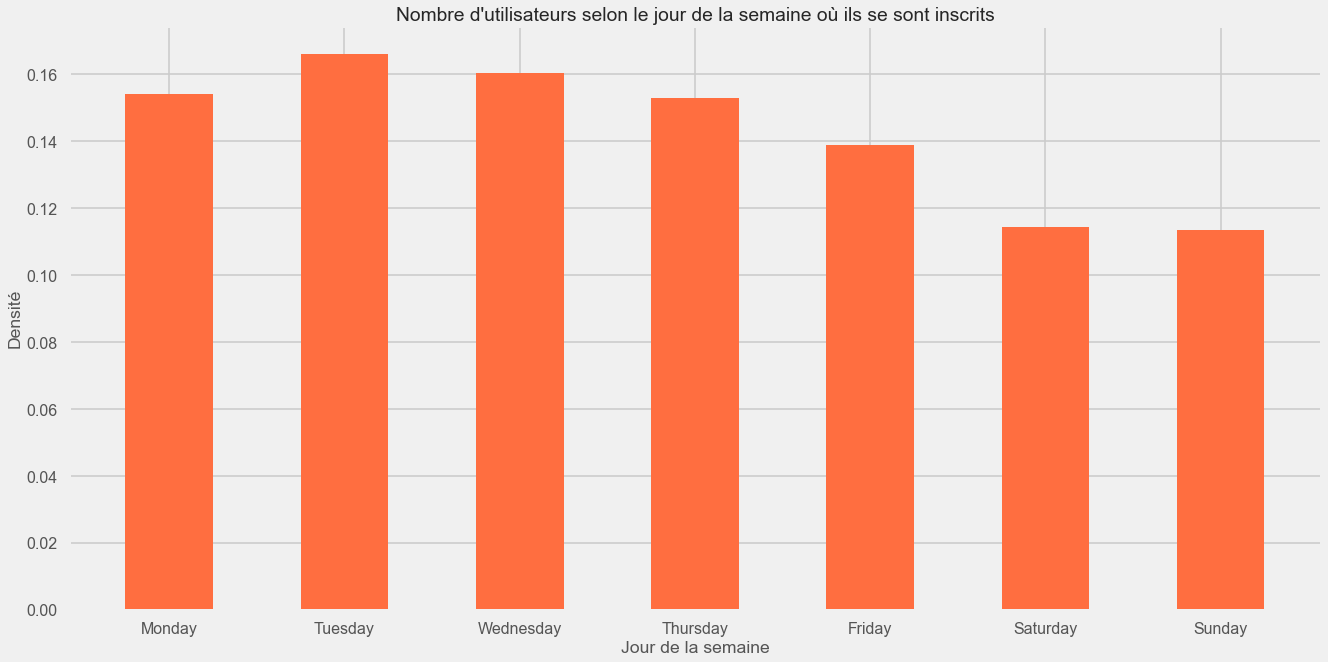

In [156]:
users['day_first_active'] = users['date_first_active'].dt.weekday + 1
ax = users['day_first_active'].hist(bins=np.arange(8)+0.5, rwidth=0.5, figsize=(20, 10), density=True, color='#ff6e40')
ax.set_title("Nombre d'utilisateurs selon le jour de la semaine où ils se sont inscrits")
ax.set_xlabel('Jour de la semaine')
ax.set_ylabel('Densité')
ax.set_xticklabels([''] + [name for name in calendar.day_name])
_ = ax.set_ylabel("Densité") 

On voit que : 
* les individus s'inscrit régulièrement en début de semaine (mardi étant le jour où il y a le plus d'inscriptions);
* il y a une baisse d'activités le week-end.

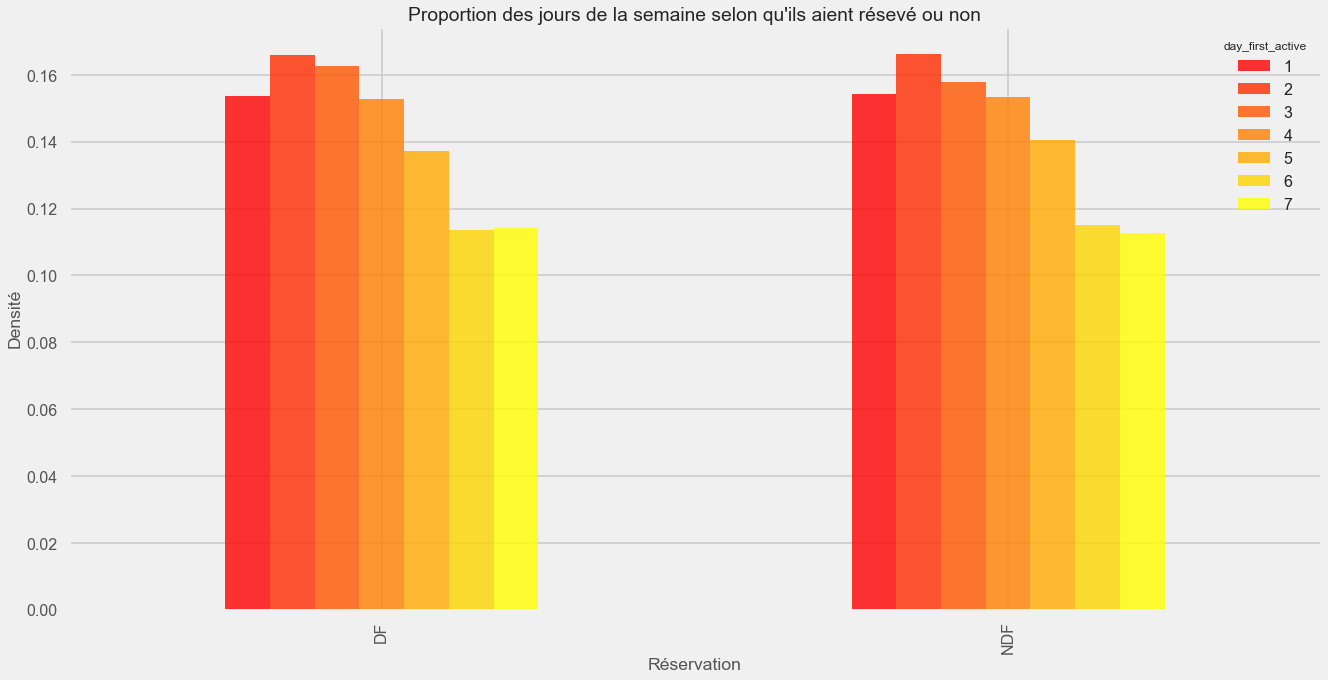

In [157]:
var = pd.crosstab(users['destination_found'], users['day_first_active'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, figsize=(20, 10), colormap='autumn', alpha=0.8)
plt.ylabel('Densité')
plt.xlabel('Réservation')
_ = plt.title("Proportion des jours de la semaine selon qu'ils aient résevé ou non")

Les graphiques ne montrent aucun moyen de séparer les utilisateurs qui réservent et ceux qui ne le font pas. Cette variable n'est donc pas intéressante pour résoudre notre problème.

#### Le nombre d'inscrit selon le moment de la journée

On suppose ici que le fuseau horaire est le même pour tous les utilisateurs.

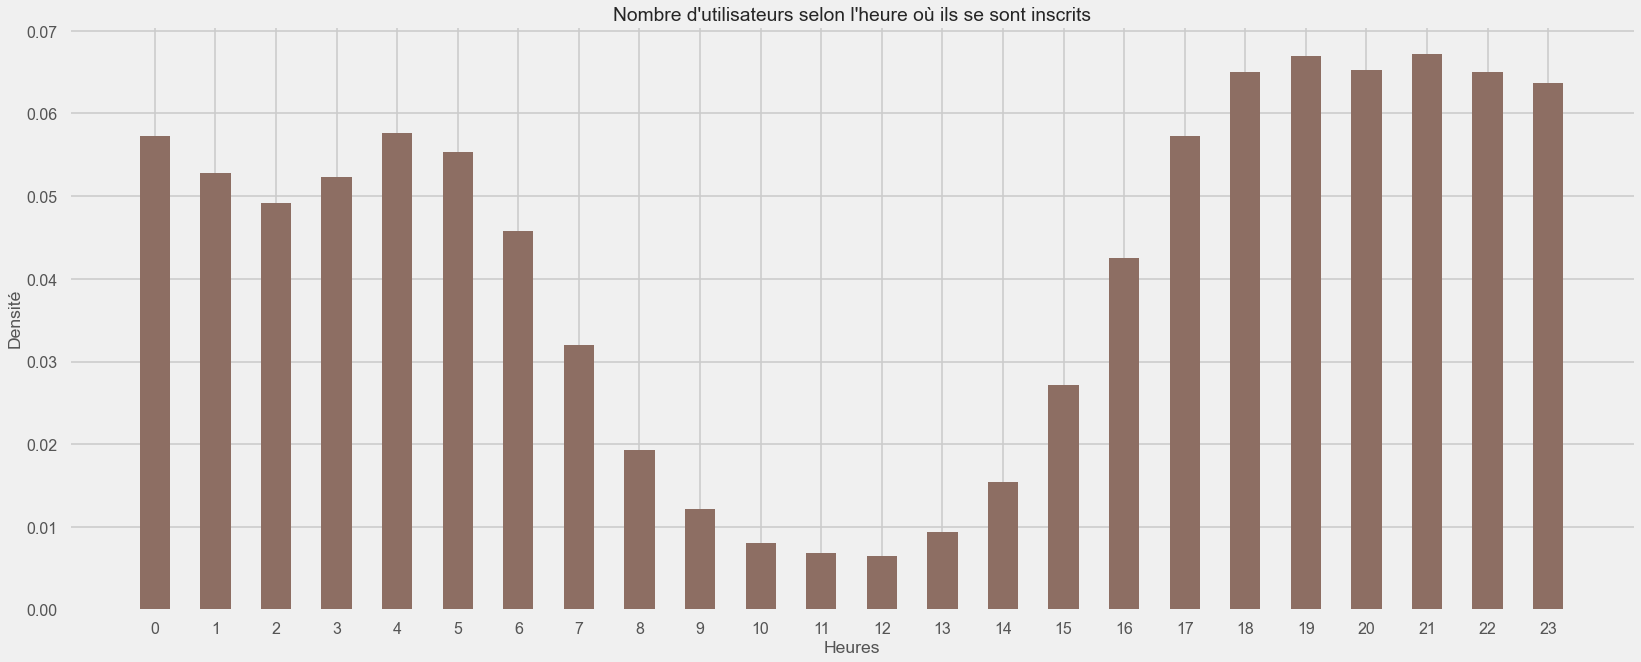

In [158]:
ax = users['hour_first_active'].hist(bins=np.arange(25)-0.5, rwidth=0.5, figsize=(25, 10), density=True, color='#8d6e63')
ax.set_title("Nombre d'utilisateurs selon l'heure où ils se sont inscrits")
ax.set_ylabel('Densité')
ax.set_xticks(range(24))
_ = ax.set_xlabel('Heures')

La plupart des personnes se sont inscrits le soir et une minorité en début de journée. Il y a une population importante de personnes qui s'inscrivent durant la nuit.

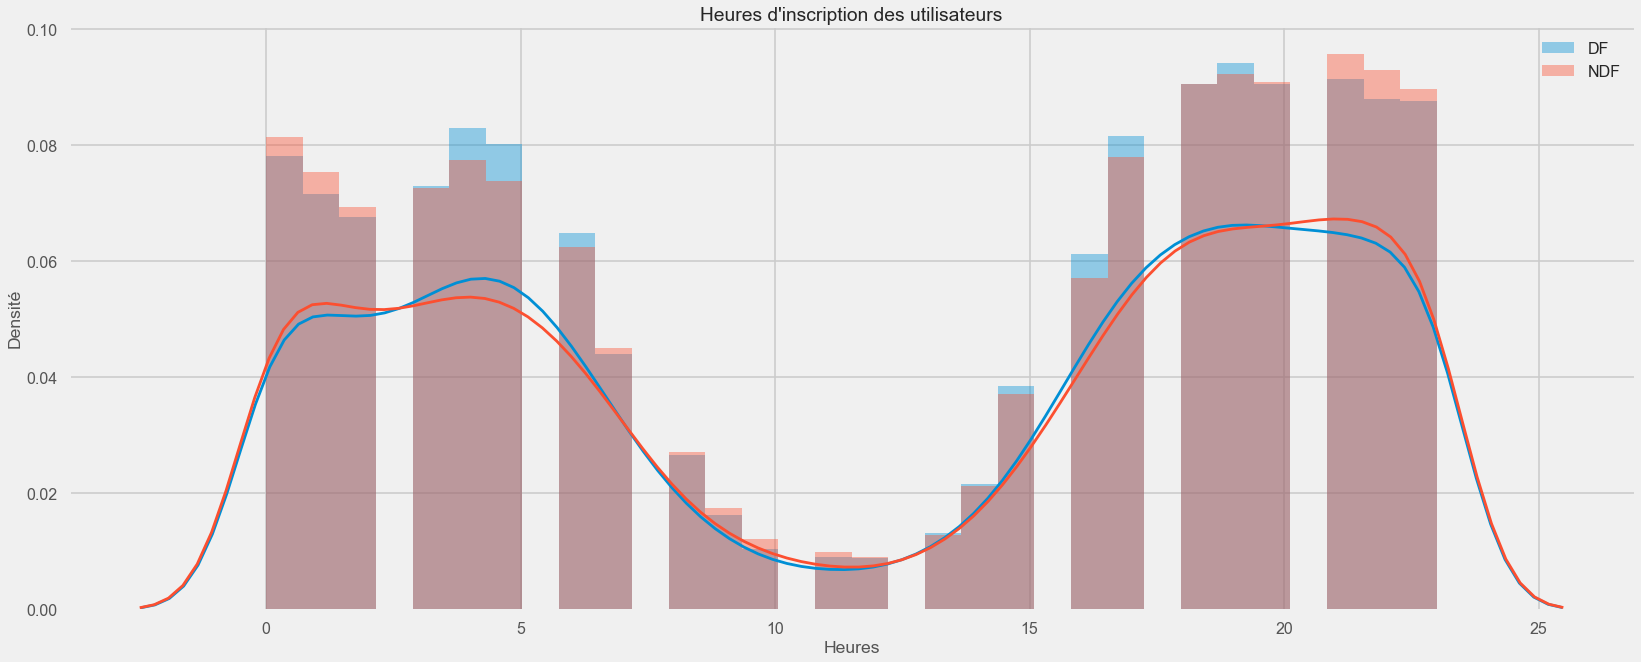

In [159]:
plt.figure(figsize=(25, 10))
sns.distplot(users[users['destination_found'] == 'DF']['hour_first_active'], label='DF')
sns.distplot(users[users['destination_found'] == 'NDF']['hour_first_active'], label='NDF')
plt.xlabel('Heures')
plt.ylabel('Densité')
plt.title("Heures d'inscription des utilisateurs")
plt.legend()
# _ = plt.xticks(range(0, 24))

* Un légère tendance à réserver du côté des utilisateurs inscrits de 3 à 7h et de 15 à 20h.
* Un légère tendance à ne pas réserver du côté des utilisateurs inscrits de minuit à 3h, de 7 à 12h et après 20h.

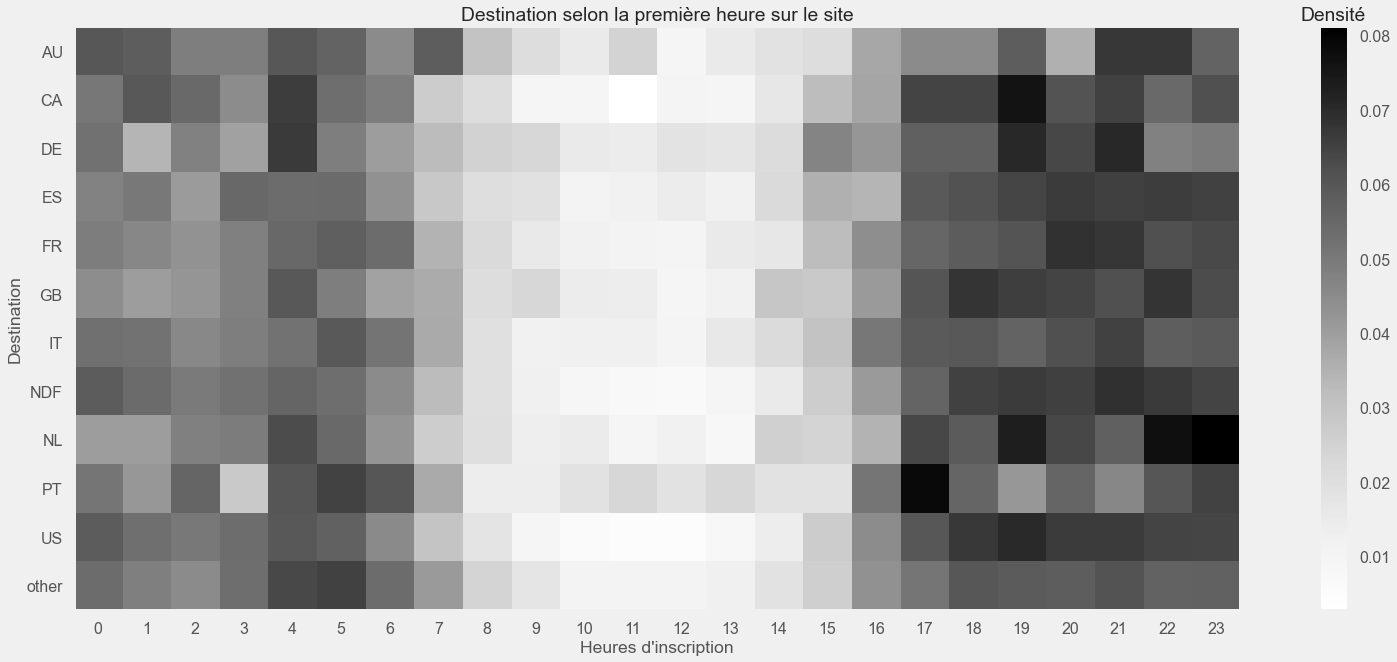

In [160]:
hours = np.zeros((24, 12))
dests = np.unique(users['country_destination'])
for h in range(24):
    for dest in range(12):
        hours[h][dest] = users[(users['country_destination'] == dests[dest]) & (users['hour_first_active'] == h)].shape[0] / users[users['country_destination'] == dests[dest]].shape[0]
fig, ax = plt.subplots(figsize=(25, 10))

ax.set_title("Destination selon la première heure sur le site")
ax.set_xticks(np.arange(24))
ax.set_yticks(np.arange(12))
ax.set_xticklabels(range(24))
ax.set_yticklabels(dests)
ax.grid(False)
im = ax.imshow(hours.T)
ax.set_ylabel('Destination')
ax.set_xlabel("Heures d'inscription")
_ = fig.colorbar(im, orientation='vertical').ax.set_title("Densité")

* Une forte proportion des utilisateurs ayant réservé au Portugal (PT) sont arrivé à 17h.
* Les utilisateurs réservant aux Pays-Bas (NL) sont arrivés de 22 à 23h.
* Pour l'Australie (AU), il semblerait qu'il y a aient autant d'utilisateurs la nuit (minuit->6h) que le soir (18h->minuit).

## Le nombre d'inscrits selon l'année

On va étudier l'évolution du nombre d'inscrit selon l'année. 

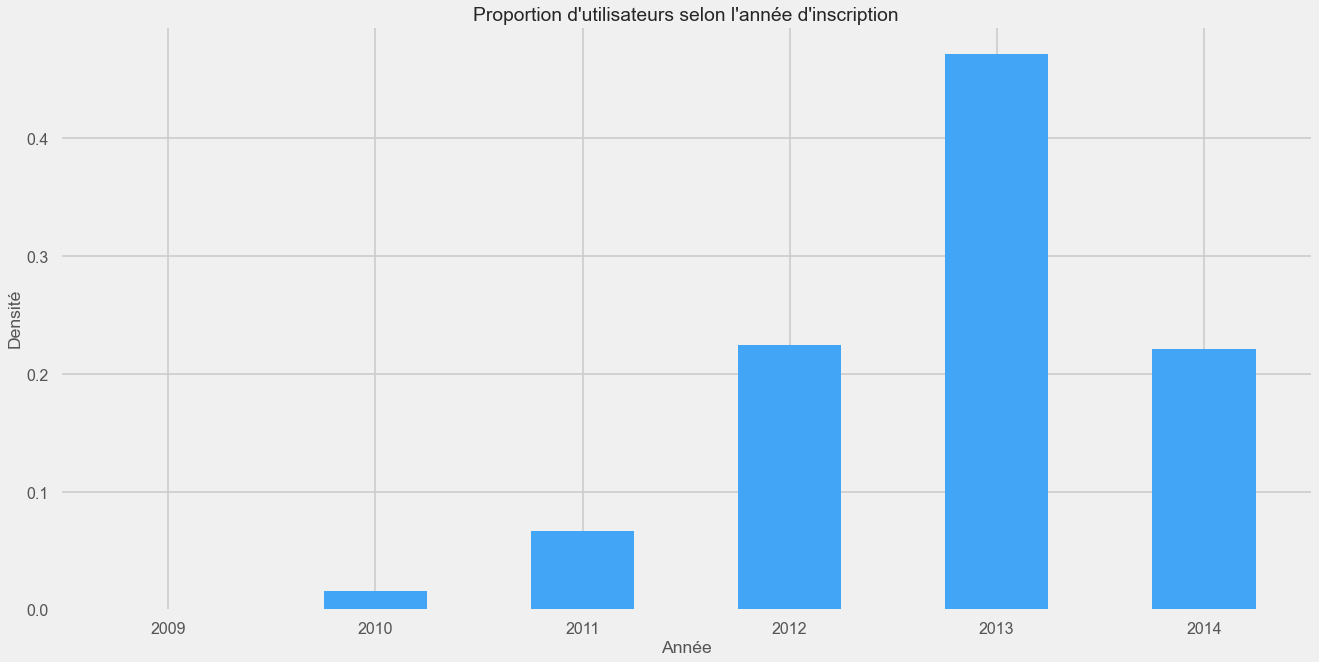

In [161]:
n_years = users['year_first_active'].nunique()
first_year = users['year_first_active'].unique().min()
ax = users['year_first_active'].hist(density=True, bins=np.arange(n_years+1)-0.5+first_year, rwidth=0.5, figsize=(20, 10), color='#42a5f5')
ax.set_title("Proportion d'utilisateurs selon l'année d'inscription")
ax.set_ylabel('Densité')
_ = ax.set_xlabel('Année')

On voit clairement que le nombre d'inscrit augmente au fil des années. Il faut considérer le fait que l'année 2014 contient seulement une partie des utilisateurs inscrits puisque le dataset a été fait durant l'année 2014.

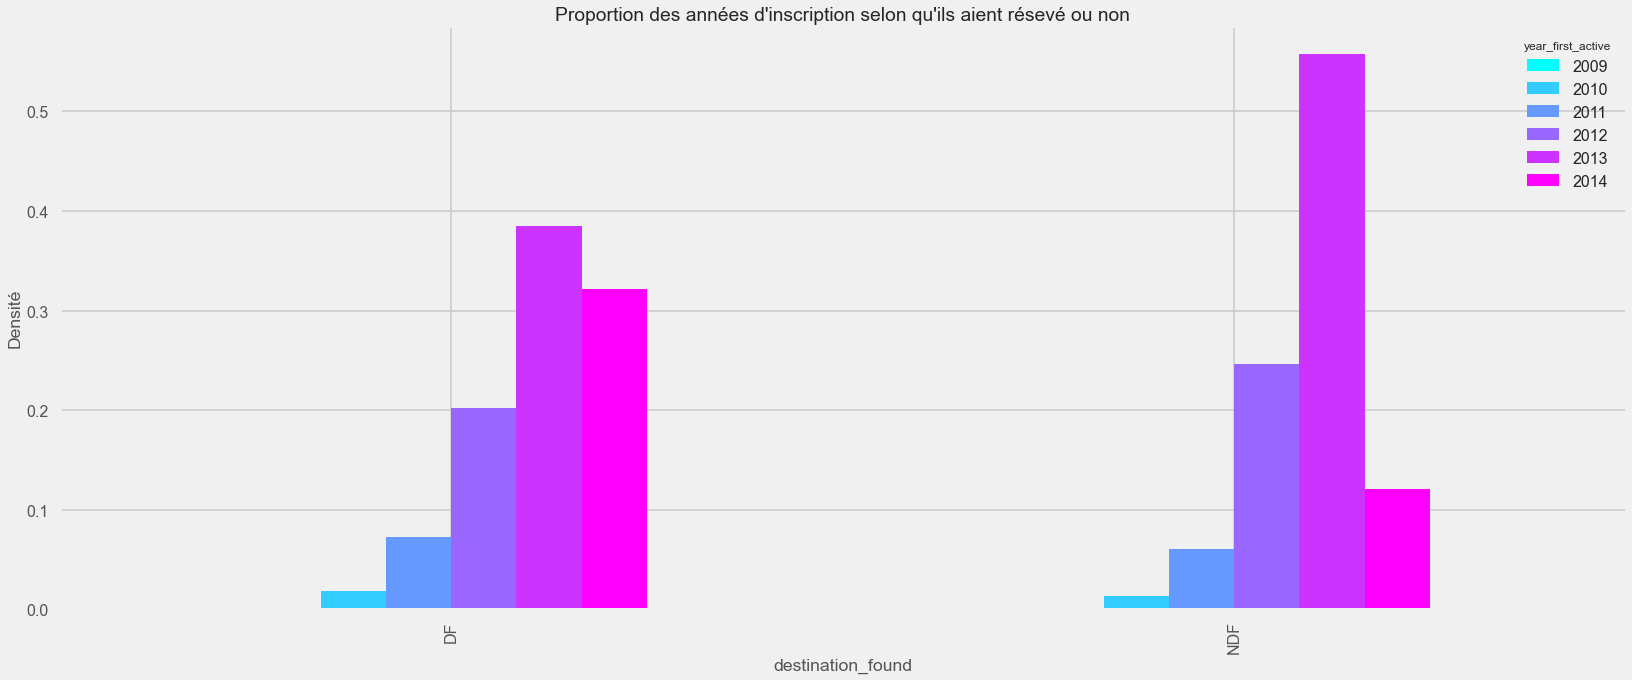

In [162]:
var = pd.crosstab(users['destination_found'], users['year_first_active'])
ax = var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, figsize=(25, 10), colormap='cool')
ax.set_ylabel("Densité")
_ = ax.set_title("Proportion des années d'inscription selon qu'ils aient résevé ou non")

On voit que le nombre de NDF est majoritaire durant l'année 2012 et 2013. 

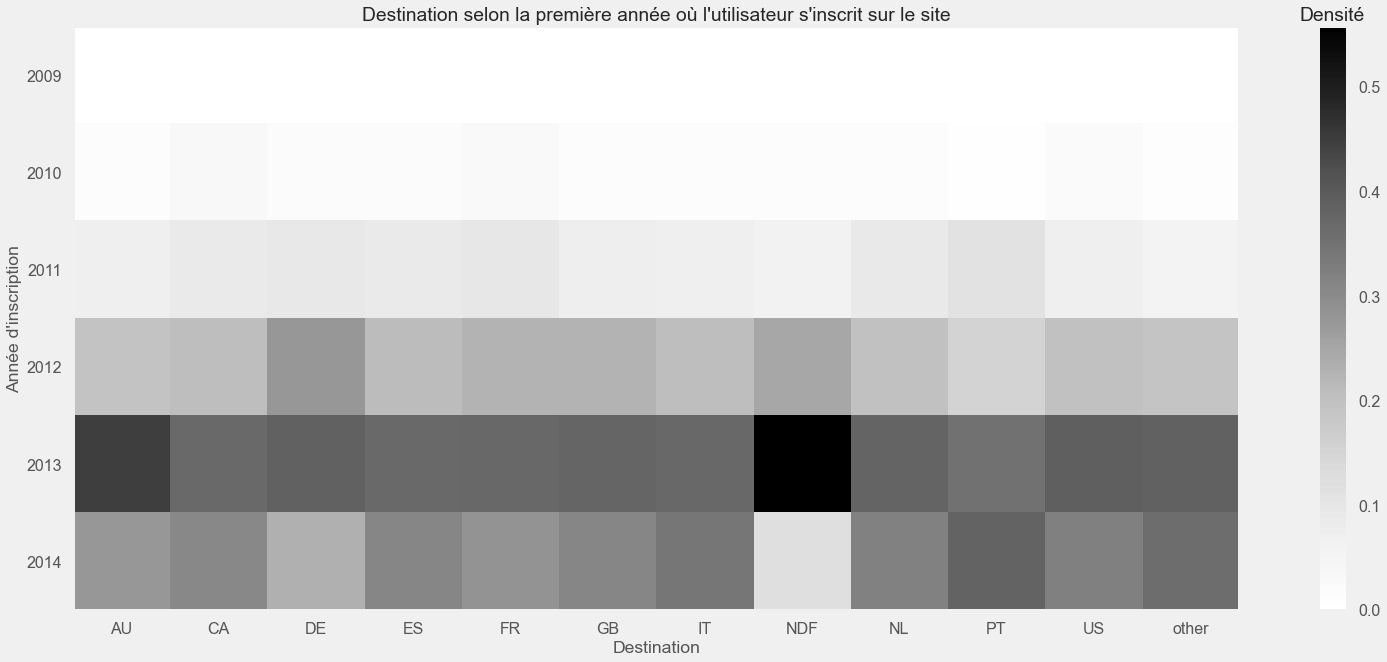

In [163]:
dests = np.unique(users['country_destination'])
years = np.unique(users['year_first_active'])
mat_years = np.zeros((len(years), 12))

for dest in range(12):
    n = users[users['country_destination'] == dests[dest]].shape[0]
    for y in range(len(years)):
        mat_years[y][dest] = users[(users['country_destination'] == dests[dest]) & (users['year_first_active'] == years[y])].shape[0] / n
fig, ax = plt.subplots(figsize=(25, 10))

ax.set_title("Destination selon la première année où l'utilisateur s'est inscrit")
ax.set_yticks(np.arange(years.shape[0]))
ax.set_xticks(np.arange(12))
ax.set_yticklabels(years)
ax.set_xticklabels(dests)
ax.grid(False)
im = ax.imshow(mat_years)
ax.set_xlabel('Destination')
ax.set_ylabel("Année d'inscription")
_ = fig.colorbar(im, orientation='vertical').ax.set_title("Densité")

* En 2012, près de 40% des utilisateurs ont réservé en Allemagne.
* En 2013, la destination la plus fréquentés est l'Australie avec 45% des utilisateurs.
* En 2014, peu de NDF présent. On rappelle qu'on ne dispose pas d'utilisateurs inscrit après la fin de la prmière moitié de 2014.

## Récapitulatif

- Les DF ont tendance à renseigner leur sexe. Les NDF ont tendance à laisser cette information vide.
- L'Allemagne et les Pays-Bas sont plus réservé par les hommes tandis que l'Italie et la France par les femmes
- Les DF ont un âge plus centré vers les 30 ans. Les NDF ont une population un peu plus importante d'utilisateurs de 50 ans
- L'Espagne, le Portugal et les Etats-Unis attirent une population plus jeunes alors que la Grande-Bretagne, la France, le Canada et l'Australie une population plus vieille
- Ceux avec un âge erroné (100 -> 1000) tendent à réserver
- Les addicts de Facebook ont une légère tendance à ne pas réserver
- Ceux qui se sont  inscrits à la 2 ou 3e page de recherche ont une plus forte tendance à faire une réservation
- Ceux employant une autre langue que le français ont une légère tendance à ne pas réserver
- Les gens ont une légère tendance à réserver vers le pays correspondant à leur langage (français -> France)
- Les variables liées aux méthodes d'affiliation sont très peu riches en information (et ne permettent pas de séparer les classes)
- Les utilisateurs visitent majoritairement la plateforme d'Airbnb depuis l'application Web 
- Les NDF se connectent depuis des appareils inconnues ou cachés.
- Les NDF ont tendance à utiliser des navigateurs inconnues.

* Les utilisateurs ont tendance à réserver durant la période de mars à juin.
* Le temps médian avant de réserver est de 3 jours.
* Les individus préfèrent partir durant de période de forte chaleur ; soit en été vers les pays de l'hémisphère nord, soit en hiver vers les pays de l'hémisphère sud.